## Linear Regression

In [1]:
## Import necessary libraries

import mne
import numpy as np
import matplotlib.pyplot as plt
# import torch
from scipy.io import loadmat
from scipy.special import sph_harm
from numpy.linalg import solve
import json
import pandas as pd

In [2]:
import numpy as np
from scipy.signal import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor

In [3]:
import numpy as np, matplotlib.pyplot as plt, os
from matplotlib import gridspec
from scipy import ndimage
from ripser import ripser
from persim import plot_diagrams
import gudhi as gd
from sklearn.datasets import load_digits

try:
    from gtda.time_series import TakensEmbedding, SlidingWindow
    from gtda.homology import VietorisRipsPersistence
    from gtda.plotting import plot_diagram
    from gtda.diagrams import PersistenceLandscape, PersistenceSilhouette
    from gtda.diagrams import Scaler, Filtering
    HAVE_GIOTTO = True
except Exception:
    HAVE_GIOTTO = False

In [4]:
good = [2, 3, 4, 6, 7, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31, 33, 34, 36, 38, 40, 41, 42, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 65]
good = np.array(good) - 1
subjects = ["01", "02", "04", "09", "15", "37", "79"]
auds = [f"{i:02d}" for i in range(1, 24)]

bad = set(range(65)) - set(good)

san_disk = 'D:/Universidad/2025_2/TDA/data'
san_results = 'D:/Universidad/2025_2/TDA/results'

In [5]:
import numpy as np
from scipy.signal import hilbert, butter, filtfilt, find_peaks
from scipy.interpolate import interp1d
import librosa

# ---------------------------------------------------------
# 1. Hilbert envelope
# ---------------------------------------------------------
def envelope_hilbert(y, sr, smooth_ms=10):
    """Hilbert transform envelope, optionally smoothed with moving average."""
    analytic = hilbert(y)
    env = np.abs(analytic)
    win = int(smooth_ms * sr / 1000)
    if win > 1:
        env = np.convolve(env, np.ones(win)/win, mode='same')
    return env


# ---------------------------------------------------------
# 2. Rectify + Lowpass filter envelope
# ---------------------------------------------------------
def envelope_lowpass(y, sr, cutoff_hz=20, order=4):
    """Envelope via full-wave rectification and Butterworth lowpass."""
    rect = np.abs(y)
    nyq = 0.5 * sr
    b, a = butter(order, cutoff_hz / nyq, btype='low')
    env = filtfilt(b, a, rect)
    return env


# ---------------------------------------------------------
# 3. RMS (root-mean-square) envelope
# ---------------------------------------------------------
def envelope_rms(y, sr, frame_ms=128, hop_ms=None):
    """RMS energy envelope over frames."""
    frame = int(frame_ms * sr / 1000)
    hop = int(hop_ms * sr / 1000) if hop_ms else frame // 2
    rms = librosa.feature.rms(y=y, frame_length=frame, hop_length=hop)[0]
    # Upsample to original signal length
    env = np.repeat(rms, hop)
    return env[:len(y)]


# ---------------------------------------------------------
# 4. Peak interpolation envelope
# ---------------------------------------------------------
def envelope_peaks(y, sr, peak_thresh=0.01, min_dist_ms=20):
    """Envelope by finding peaks and interpolating between them."""
    rect = np.abs(y)
    min_dist = int(min_dist_ms * sr / 1000)
    peaks, _ = find_peaks(rect, height=np.max(rect)*peak_thresh, distance=min_dist)

    if len(peaks) < 2:  # fallback: return rectified signal
        return rect

    xs = np.concatenate(([0], peaks, [len(y)-1]))
    ys = np.concatenate(([rect[0]], rect[peaks], [rect[-1]]))
    f = interp1d(xs, ys, kind='linear')
    env = f(np.arange(len(y)))
    return env


# ---------------------------------------------------------
# 5. Exponential smoothing envelope (attack/release)
# ---------------------------------------------------------
def envelope_exponential(y, sr, attack_ms=1, release_ms=200):
    """Envelope follower with exponential attack/release smoothing."""
    x = np.abs(y)
    a_a = np.exp(-1.0 / (sr * attack_ms / 1000.0))
    a_r = np.exp(-1.0 / (sr * release_ms / 1000.0))
    env = np.zeros_like(x)
    for n in range(1, len(x)):
        coeff = a_a if x[n] > env[n-1] else a_r
        env[n] = coeff * env[n-1] + (1 - coeff) * x[n]
    return env

#### Method 0.

In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

def method_1_regression(eeg, aud):
    X = eeg  # (958, 47, 3)
    X = X.reshape(X.shape[0], -1)              # (958, 141)
    y = aud                      # (958, 3)

    # Fit linear regression
    model = LinearRegression()
    model.fit(X, y)

    # Predict
    y_pred = model.predict(X)
    pearsons = [pearsonr(y[:, i], y_pred[:, i])[0] for i in range(y.shape[1])]
    mse = np.mean((y - y_pred) ** 2, axis=0)
    return np.array(pearsons), np.array(mse), model, y_pred

In [8]:
XF = []
yF = []
gF = []
XS = []
yS = []
gS = []

for s in range(2):
    if s == 0:
        speed = 'fast'
    else:
        speed = 'slow'
    for m in range(7):
        bb = subjects[m]
        for n in range(len(auds)):
            ut = auds[n]
            # Load audio file
            try:
                data = loadmat(f'data/sound_sep/{speed}/bb{bb}_ut{ut}.mat')
            except FileNotFoundError:
                continue

            eeg = data["subeeg"]
            aud = data["y"]
            aud = aud[:,0]
            Fs = data["Fs"]
            fs = 64
            aud_resample = aud[::int(Fs/250)]
            aud_resample = aud_resample[::int(250/fs)]
            eeg_resample = eeg[::int(250/fs), good]

            if len(aud_resample) > len(eeg_resample):
                aud_resample = aud_resample[:len(eeg_resample)]
            elif len(eeg_resample) > len(aud_resample):
                eeg_resample = eeg_resample[:len(aud_resample)]

            aud_resample = (aud_resample - np.mean(aud_resample, axis=0)) / np.std(aud_resample, axis=0)
            eeg_resample = (eeg_resample - np.mean(eeg_resample, axis=0)) / np.std(eeg_resample, axis=0)
            
            aud_envelope = envelope_hilbert(aud_resample, fs).tolist()

            if speed == 'fast':
                XF.append(eeg_resample)
                yF.append(aud_envelope)
                gF.append(m)
            else:
                XS.append(eeg_resample)
                yS.append(aud_envelope)
                gS.append(m)


C:\Users\marti\AppData\Local\Temp\ipykernel_28352\396726977.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  aud_resample = aud[::int(Fs/250)]


In [6]:
import numpy as np
from scipy.signal import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor


def regress_models(X_raw, y_raw, subjects, method = "Ridge", candidates = [{"alpha": 1}, {"alpha": 2}], verb=0):
    
    target_len = 888  # pick desired uniform length
    X_fixed = []
    y_fixed = []

    for X, y in zip(X_raw, y_raw):
        # Resample EEG (each channel)
        Xr = X[:target_len, :]  # truncate or pad as needed
        # Flatten: channels * time
        X_flat = Xr.reshape(-1)
        X_fixed.append(X_flat)

        # Resample audio
        yr = y[:target_len]  # truncate or pad as needed
        y_fixed.append(yr)

    X_fixed = np.array(X_fixed)
    y_fixed = np.array(y_fixed)
    subjects = np.array(subjects)
    if verb:
        print(X_fixed.shape, y_fixed.shape, subjects.shape)


    #########################################
    # 3) Train/Test subject split
    #########################################

    train_subjects = [1, 2, 3, 4]  # example subjects for training
    test_subjects  = [0, 6]           # held-out test subjects

    train_mask = np.isin(subjects, train_subjects)
    test_mask  = np.isin(subjects, test_subjects)

    X_train, y_train = X_fixed[train_mask], y_fixed[train_mask]
    X_test,  y_test  = X_fixed[test_mask],  y_fixed[test_mask]
    groups_train    = subjects[train_mask]


    #########################################
    # 4) Standardization (fit only on training!)
    #########################################

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)


    #########################################
    # 5) GroupKFold CV on training subjects
    #########################################

    gkf = GroupKFold(n_splits=len(train_subjects))


    best_score = -np.inf
    best_params = 0
    if verb:
        print("Starting Train Stage")
    for n_id, n_comp in enumerate(candidates):
        fold_scores = []

        for train_idx, val_idx in gkf.split(X_train_scaled, y_train, groups_train):
            if method == "Ridge":
                model = Ridge(**n_comp)
            elif method == "PLS":
                model = PLSRegression(**n_comp)
            elif method == "KRidge":
                model = KernelRidge(**n_comp)
            elif method == "MLP":
                model = MLPRegressor(**n_comp)
            model.fit(X_train_scaled[train_idx], y_train[train_idx])
            y_pred = model.predict(X_train_scaled[val_idx])

            corrs = [pearsonr(y_pred[i].ravel(), y_train[val_idx][i].ravel())[0]
                    for i in range(len(val_idx))]
            fold_scores.append(np.nanmean(corrs))

        avg_score = np.mean(fold_scores)


        if avg_score > best_score:
            best_score = avg_score
            best_params = n_id
    if verb:
        print("\nBest hyperparameters:", best_params)
        print("Best CV Score:", best_score)


    #########################################
    # 6) Retrain final model on all training subjects
    #########################################
    if verb:
        print("Starting Test Stage")
    if method == "Ridge":
        final_model = Ridge(**candidates[best_params])
    elif method == "PLS":
        final_model = PLSRegression(**candidates[best_params])
    elif method == "KRidge":
        final_model = KernelRidge(**candidates[best_params])
    elif method == "MLP":
        final_model = MLPRegressor(**candidates[best_params])
    final_model.fit(X_train_scaled, y_train)

    #########################################
    # 7) Evaluate on held-out test subjects
    #########################################

    y_test_pred = final_model.predict(X_test_scaled)

    corrs = [pearsonr(y_test_pred[i].ravel(), y_test[i].ravel())[0]
                        for i in range(45)]

    test_score = np.array(corrs).mean()

    if verb:
        print("\nFinal Test Score:", test_score)

    return y_test, y_test_pred, test_score, corrs


In [ ]:
df_scores = pd.DataFrame(columns=["Model", "Method", "Subject", "Trial", "Speed", "Band", "Emb", "Tau", "Type", "Score"])
df_scores.to_csv("scores_.csv")

In [10]:
params = [{"alpha":2**i} for i in range(-5,5)]

ytestF, ypredF, scoreF, pearF = regress_models(XF, yF, gF, method = "Ridge", candidates=params)
ytestS, ypredS, scoreS, pearS = regress_models(XS, yS, gS, method = "Ridge", candidates=params)

if scoreF < scoreS:
    print(f"Slow outperforms Fast with Ridge")
else:
    print(f"Fast outperforms Slow with Ridge")


Slow outperforms Fast with Ridge


In [42]:
rows = []
for m in range(2):
    for n in range(23 - m):
        for s in range(2):
            row = {
                "Model": 0,
                "Method": 0,
                "Subject": m*6 + 1,
                "Trial": n + 1,
                "Speed": s,
                "Band": 0,
                "Emb": 0,
                "Tau": 0,
                "Type": 0,
                "Score": pearF[23*m + n] if s == 0 else pearS[23*m + n]
            }
            rows.append(row)

In [43]:
params = [{"alpha":2**i, "gamma": j} for i in range(-5,5) for j in [1e-3, 1e-2,5e-3]]

ytestF, ypredF, scoreF, pearF = regress_models(XF, yF, gF, method = "KRidge", candidates=params)
ytestS, ypredS, scoreS, pearS = regress_models(XS, yS, gS, method = "KRidge", candidates=params)

if scoreF < scoreS:
    print(f"Slow outperforms Fast with KernelRidge")
else:
    print(f"Fast outperforms Slow with KernelRidge")

Slow outperforms Fast with KernelRidge


In [44]:
for m in range(2):
    for n in range(23 - m):
        for s in range(2):
            row = {
                "Model": 0,
                "Method": 1,
                "Subject": m*6 + 1,
                "Trial": n + 1,
                "Speed": s,
                "Band": 0,
                "Emb": 0,
                "Tau": 0,
                "Type": 0,
                "Score": pearF[23*m + n] if s == 0 else pearS[23*m + n]
            }
            rows.append(row)

In [45]:
params = [{"n_components":5*i} for i in range(1,25,3)]

ytestF, ypredF, scoreF, pearF = regress_models(XF, yF, gF, method = "PLS", candidates=params)
ytestS, ypredS, scoreS, pearS = regress_models(XS, yS, gS, method = "PLS", candidates=params)

if scoreF < scoreS:
    print(f"Slow outperforms Fast with PLS")
else:
    print(f"Fast outperforms Slow with PLS")

c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 65
  warnings.warn(f"Y residual is constant at iteration {k}")
c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 65
  warnings.warn(f"Y residual is constant at iteration {k}")
c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 66
  warnings.warn(f"Y residual is constant at iteration {k}")
c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 67
  warnings.warn(f"Y residual is constant at iteration {k}")
c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cross_decomposi

Slow outperforms Fast with PLS


In [46]:
for m in range(2):
    for n in range(23 - m):
        for s in range(2):
            row = {
                "Model": 0,
                "Method": 2,
                "Subject": m*6 + 1,
                "Trial": n + 1,
                "Speed": s,
                "Band": 0,
                "Emb": 0,
                "Tau": 0,
                "Type": 0,
                "Score": pearF[23*m + n] if s == 0 else pearS[23*m + n]
            }
            rows.append(row)

In [47]:
params = [{"hidden_layer_sizes":3*i} for i in range(1,25,5)]

ytestF, ypredF, scoreF, pearF = regress_models(XF, yF, gF, method = "MLP", candidates=params)
ytestS, ypredS, scoreS, pearS = regress_models(XS, yS, gS, method = "MLP", candidates=params)

if scoreF < scoreS:
    print(f"Slow outperforms Fast with MLP")
else:
    print(f"Fast outperforms Slow with MLP")

c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

Slow outperforms Fast with MLP


In [48]:
for m in range(2):
    for n in range(23 - m):
        for s in range(2):
            row = {
                "Model": 0,
                "Method": 3,
                "Subject": m*6 + 1,
                "Trial": n + 1,
                "Speed": s,
                "Band": 0,
                "Emb": 0,
                "Tau": 0,
                "Type": 0,
                "Score": pearF[23*m + n] if s == 0 else pearS[23*m + n]
            }
            rows.append(row)

In [49]:
df_scores = pd.concat([df_scores, pd.DataFrame(rows)], ignore_index=True)

C:\Users\marti\AppData\Local\Temp\ipykernel_28352\3371139321.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_scores = pd.concat([df_scores, pd.DataFrame(rows)], ignore_index=True)


In [ ]:
df_scores = pd.concat([df_scores, pd.DataFrame(rows)], ignore_index=True)
df_scores.to_csv("scores.csv", index=False)

In [30]:
del XF
del yF
del gF
del XS
del yS
del gS

#### Method 1.

In [8]:
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

def method_1_regression(eeg, aud):
    X = eeg  # (958, 47, 3)
    X = X.reshape(X.shape[0], -1)              # (958, 141)
    y = aud                      # (958, 3)

    # Fit linear regression
    model = LinearRegression()
    model.fit(X, y)

    # Predict
    y_pred = model.predict(X)
    pearsons = [pearsonr(y[:, i], y_pred[:, i])[0] for i in range(y.shape[1])]
    mse = np.mean((y - y_pred) ** 2, axis=0)
    return np.array(pearsons), np.array(mse), model, y_pred


In [225]:
with open(san_disk + '/audios/method_1/fast/ut01_emb3_audio.json', 'r') as file:
        audio_data = json.load(file)

with open(san_disk + '/eegs/method_1/fast/bb01_ut01_ch1_emb3.json', 'r') as file:
        eeg_data = json.load(file)

In [32]:
XF = {(0,0): [], (0,1): [], (0,2): [], (1,0): [], (1,1): [], (1,2): []}
yF = {(0,0): [], (0,1): [], (0,2): [], (1,0): [], (1,1): [], (1,2): []}
gF = {(0,0): [], (0,1): [], (0,2): [], (1,0): [], (1,1): [], (1,2): []}
XS = {(0,0): [], (0,1): [], (0,2): [], (1,0): [], (1,1): [], (1,2): []}
yS = {(0,0): [], (0,1): [], (0,2): [], (1,0): [], (1,1): [], (1,2): []}
gS = {(0,0): [], (0,1): [], (0,2): [], (1,0): [], (1,1): [], (1,2): []}

In [24]:
prop = np.zeros((7,23))



for m in range(7):
    bb = subjects[m]
    for n in range(len(auds)):
        ut = auds[n]
        considering = 1
        for s in range(2):
            if s == 0:
                speed = 'fast'
            else:
                speed = 'slow'
            try:
                data = loadmat(f'data/sound_sep/{speed}/bb{bb}_ut{ut}.mat')
            except FileNotFoundError:
                considering = 0
                continue
        if considering:
            prop[m,n] = 1

In [77]:
ness = np.array(prop).sum(axis=1)

In [79]:
ness.sum()

153.0

In [83]:
len(XS[(0,0)])

156

In [137]:
countF = 0
countS = 0

maskF = []
maskS = []

for m in range(7):
    bb = subjects[m]
    for n in range(len(auds)):
        ut = auds[n]
        stacker = []
        for s in range(2):
            if s == 0:
                speed = 'fast'
            else:
                speed = 'slow'
            try:
                data = loadmat(f'data/sound_sep/{speed}/bb{bb}_ut{ut}.mat')
                if s == 0:
                    countF += 1
                else:
                    countS += 1
            except FileNotFoundError:
                print(f"BB{m}, UT{n} not present")
                stacker.append(s + 1)
                continue
        # print(stacker)
        if len(stacker) == 1:
            if stacker[0] == 1:
                print(f"Remove index {ness[m]*m + n} from Slow")
            elif stacker[0] == 2:
                print(f"Remove index {ness[m]*m + n} from Fast")
        if len(stacker) == 2:
            print(f"Okay neither should be there {ness[m]*m + n}")


BB1, UT0 not present
Remove index 21.0 from Fast
BB1, UT15 not present
Remove index 36.0 from Fast
BB2, UT3 not present
Remove index 47.0 from Fast
BB3, UT2 not present
Remove index 62.0 from Fast
BB3, UT9 not present
BB3, UT9 not present
Okay neither should be there 69.0
BB3, UT10 not present
Remove index 70.0 from Slow
BB4, UT7 not present
Remove index 95.0 from Slow
BB6, UT12 not present
Remove index 144.0 from Slow


In [33]:
for s in range(2):
    if s == 0:
        speed = 'fast'
    else:
        speed = 'slow'
    for m in range(7):
        bb = subjects[m]
        for n in range(len(auds)):
            ut = auds[n]
            if prop[m,n]:
                print(f"Working on bb{bb}_ut{ut} on speed {speed}")
                for eid, emb in enumerate([30, 50, 64]):
                    for tid, tau in enumerate(["", "_tau10"]):
                        if eid == 0 and tid == 0:
                            continue
                        # Load audio file

                        with open(f'{san_disk}/audios/method_1/{speed}/ut{ut}_emb{emb}{tau}_hilbert.json', 'r') as file:
                                aud = json.load(file)
                        aud = np.array(aud)
                                
                        eeg = []
                        for c in range(47):
                            with open(f'{san_disk}/eegs/method_1/{speed}/bb{bb}_ut{ut}_ch{c+1}_emb{emb}{tau}.json', 'r') as file:
                                eeg_data = json.load(file)
                            eeg.append(np.array(eeg_data))
                        eeg = np.stack(eeg, axis=1)

                        
                        if s == 0:
                            XF[(tid, eid)].append(eeg)
                            yF[(tid, eid)].append(aud)
                            gF[(tid, eid)].append(m)
                        else:
                            XS[(tid, eid)].append(eeg)
                            yS[(tid, eid)].append(aud)
                            gS[(tid, eid)].append(m)

Working on bb01_ut01 on speed fast
Working on bb01_ut02 on speed fast
Working on bb01_ut03 on speed fast
Working on bb01_ut04 on speed fast
Working on bb01_ut05 on speed fast
Working on bb01_ut06 on speed fast
Working on bb01_ut07 on speed fast
Working on bb01_ut08 on speed fast
Working on bb01_ut09 on speed fast
Working on bb01_ut10 on speed fast
Working on bb01_ut11 on speed fast
Working on bb01_ut12 on speed fast
Working on bb01_ut13 on speed fast
Working on bb01_ut14 on speed fast
Working on bb01_ut15 on speed fast
Working on bb01_ut16 on speed fast
Working on bb01_ut17 on speed fast
Working on bb01_ut18 on speed fast
Working on bb01_ut19 on speed fast
Working on bb01_ut20 on speed fast
Working on bb01_ut21 on speed fast
Working on bb01_ut22 on speed fast
Working on bb01_ut23 on speed fast
Working on bb02_ut02 on speed fast
Working on bb02_ut03 on speed fast
Working on bb02_ut04 on speed fast
Working on bb02_ut05 on speed fast
Working on bb02_ut06 on speed fast
Working on bb02_ut07

In [149]:
XF_aux = XF[(1,2)].copy()
yF_aux = yF[(1,2)].copy()
gF_aux = gF[(1,2)].copy()
XS_aux = XS[(1,2)].copy()
yS_aux = yS[(1,2)].copy()
gS_aux = gS[(1,2)].copy()


minim = 10000

for i in range(153):#XF_aux:
    if XF_aux[i].shape[0] < minim:
        minim = XF_aux[i].shape[0]
        print(f"Current mininum {XF_aux[i].shape}")

Current mininum (330, 47, 64)
Current mininum (258, 47, 64)


In [15]:
# Remove index 21.0 from Fast
# Remove index 36.0 from Fast
# Remove index 47.0 from Fast
# Remove index 62.0 from Fast
# Okay neither should be there 69.0
# Remove index 70.0 from Slow
# Remove index 95.0 from Slow
# Remove index 144.0 from Slow

# gF_aux.pop(21)

In [150]:
for i in range(len(XF_aux)):
    XF_aux[i] = XF_aux[i][:258]
    yF_aux[i] = yF_aux[i][:258]
    XS_aux[i] = XS_aux[i][:258]
    yS_aux[i] = yS_aux[i][:258]
    gF_aux[i] = gF_aux[i]
    gS_aux[i] = gS_aux[i]

XF_aux = np.array(XF_aux)
yF_aux = np.array(yF_aux)
gF_aux = np.array(gF_aux)
XS_aux = np.array(XS_aux)
yS_aux = np.array(yS_aux)
gS_aux = np.array(gS_aux)

In [ ]:
# def regress_models_1(X_raw, y_raw, subjects, method = "Ridge", candidates = [{"alpha": 1}, {"alpha": 2}], verb=0):
    
#     target_len = 589  # pick desired uniform length
#     X_fixed = []
#     y_fixed = []

#     for X, y in zip(X_raw, y_raw):
#         # Resample EEG (each channel)
#         Xr = X[:target_len, :]  # truncate or pad as needed
#         # Flatten: channels * time
#         X_flat = Xr.reshape(-1)
#         X_fixed.append(X_flat)

#         # Resample audio
#         yr = y[:target_len]  # truncate or pad as needed
#         y_fixed.append(yr)

#     X_fixed = np.array(X_fixed)
#     y_fixed = np.array(y_fixed)
#     subjects = np.array(subjects)
#     if verb:
#         print(X_fixed.shape, y_fixed.shape, subjects.shape)


#     #########################################
#     # 3) Train/Test subject split
#     #########################################

#     train_subjects = [i for i in range(5, 23)]  # example subjects for training
#     test_subjects  = [i for i in range(5)]           # held-out test subjects

#     train_mask = np.isin([i for i in range(23)], train_subjects)
#     test_mask  = np.isin([i for i in range(23)], test_subjects)

#     X_train, y_train = X_fixed[train_mask], y_fixed[train_mask]
#     X_test,  y_test  = X_fixed[test_mask],  y_fixed[test_mask]
#     groups_train    = np.array([i for i in range(23)])[train_mask]


#     #########################################
#     # 4) Standardization (fit only on training!)
#     #########################################

#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled  = scaler.transform(X_test)
#     # X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
#     # X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], -1)
#     # y_train = y_train.reshape(y_train.shape[0], -1)
#     # y_test = y_test.reshape(y_test.shape[0], -1)
#     # X_train_scaled = X_train_scaled[:,::59]
#     # X_test_scaled = X_test_scaled[:,::59]
#     # y_train = y_train[:,::59]
#     # y_test = y_test[:,::59]

#     #########################################
#     # 5) GroupKFold CV on training subjects
#     #########################################

#     gkf = GroupKFold(n_splits=5)


#     best_score = -np.inf
#     best_params = 0
#     if verb:
#         print("Starting Train Stage")
#     for n_id, n_comp in enumerate(candidates):
#         fold_scores = []

#         for train_idx, val_idx in gkf.split(X_train_scaled, y_train, groups_train):
#             if method == "Ridge":
#                 model = Ridge(**n_comp)
#             elif method == "PLS":
#                 model = PLSRegression(**n_comp)
#             elif method == "KRidge":
#                 model = KernelRidge(**n_comp)
#             elif method == "MLP":
#                 model = MLPRegressor(**n_comp)
#             model.fit(X_train_scaled[train_idx], y_train[train_idx])
#             y_pred = model.predict(X_train_scaled[val_idx])

#             corrs = [pearsonr(y_pred[i].ravel(), y_train[val_idx][i].ravel())[0]
#                     for i in range(len(val_idx))]
#             fold_scores.append(np.nanmean(corrs))

#         avg_score = np.mean(fold_scores)


#         if avg_score > best_score:
#             best_score = avg_score
#             best_params = n_id
#     if verb:
#         print("\nBest hyperparameters:", best_params)
#         print("Best CV Score:", best_score)


#     #########################################
#     # 6) Retrain final model on all training subjects
#     #########################################
#     if verb:
#         print("Starting Test Stage")
#     if method == "Ridge":
#         final_model = Ridge(**candidates[best_params])
#     elif method == "PLS":
#         final_model = PLSRegression(**candidates[best_params])
#     elif method == "KRidge":
#         final_model = KernelRidge(**candidates[best_params])
#     elif method == "MLP":
#         final_model = MLPRegressor(**candidates[best_params])
#     final_model.fit(X_train_scaled, y_train)

#     #########################################
#     # 7) Evaluate on held-out test subjects
#     #########################################

#     y_test_pred = final_model.predict(X_test_scaled)

#     corrs = [pearsonr(y_test_pred[i].ravel(), y_test[i].ravel())[0]
#                         for i in range(5)]

#     test_score = np.array(corrs).mean()

#     print("\nFinal Test Score:", test_score)

#     return y_test, y_test_pred, test_score, corrs


In [151]:

def regress_models_1_2(X_raw, y_raw, subjects, method = "Ridge", candidates = [{"alpha": 1}, {"alpha": 2}], verb=0):
    
    target_len = X_raw[0].shape[0] # pick desired uniform length
    X_fixed = []
    y_fixed = []

    for X, y in zip(X_raw, y_raw):
        # Resample EEG (each channel)
        Xr = X[:target_len, :]  # truncate or pad as needed
        # Flatten: channels * time
        X_flat = Xr.reshape(-1)
        X_fixed.append(X_flat)

        # Resample audio
        yr = y[:target_len]
        y_flat = yr.reshape(-1)  # truncate or pad as needed
        y_fixed.append(y_flat)

    X_fixed = np.array(X_fixed)
    y_fixed = np.array(y_fixed)
    subjects = np.array(subjects)
    if verb:
        print(X_fixed.shape, y_fixed.shape, subjects.shape)


    #########################################
    # 3) Train/Test subject split
    #########################################

    train_subjects = [1, 2, 3, 4]  # example subjects for training
    test_subjects  = [0, 6]           # held-out test subjects

    train_mask = np.isin(subjects, train_subjects)
    test_mask  = np.isin(subjects, test_subjects)

    X_train, y_train = X_fixed[train_mask], y_fixed[train_mask]
    X_test,  y_test  = X_fixed[test_mask],  y_fixed[test_mask]
    groups_train    = subjects[train_mask]


    #########################################
    # 4) Standardization (fit only on training!)
    #########################################

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    X_train_scaled = X_train_scaled[:,::37]
    X_test_scaled = X_test_scaled[:,::37]
    y_train = y_train[:,::37]
    y_test = y_test[:,::37]


    #########################################
    # 5) GroupKFold CV on training subjects
    #########################################

    gkf = GroupKFold(n_splits=len(train_subjects))


    best_score = -np.inf
    best_params = 0
    if verb:
        print("Starting Train Stage")
    for n_id, n_comp in enumerate(candidates):
        fold_scores = []

        for train_idx, val_idx in gkf.split(X_train_scaled, y_train, groups_train):
            if method == "Ridge":
                model = Ridge(**n_comp)
            elif method == "PLS":
                model = PLSRegression(**n_comp)
            elif method == "KRidge":
                model = KernelRidge(**n_comp)
            elif method == "MLP":
                model = MLPRegressor(**n_comp)
            model.fit(X_train_scaled[train_idx], y_train[train_idx])
            y_pred = model.predict(X_train_scaled[val_idx])

            corrs = [pearsonr(y_pred[i].ravel(), y_train[val_idx][i].ravel())[0]
                    for i in range(len(val_idx))]
            fold_scores.append(np.nanmean(corrs))

        avg_score = np.mean(fold_scores)


        if avg_score > best_score:
            best_score = avg_score
            best_params = n_id
    if verb:
        print("\nBest hyperparameters:", best_params)
        print("Best CV Score:", best_score)


    #########################################
    # 6) Retrain final model on all training subjects
    #########################################
    if verb:
        print("Starting Test Stage")
    if method == "Ridge":
        final_model = Ridge(**candidates[best_params])
    elif method == "PLS":
        final_model = PLSRegression(**candidates[best_params])
    elif method == "KRidge":
        final_model = KernelRidge(**candidates[best_params])
    elif method == "MLP":
        final_model = MLPRegressor(**candidates[best_params])
    final_model.fit(X_train_scaled, y_train)

    #########################################
    # 7) Evaluate on held-out test subjects
    #########################################

    y_test_pred = final_model.predict(X_test_scaled)

    corrs = [pearsonr(y_test_pred[i].ravel(), y_test[i].ravel())[0]
                        for i in range(len(y_test_pred))]

    test_score = np.array(corrs).mean()

    if verb:
        print("\nFinal Test Score:", test_score)

    return y_test, y_test_pred, test_score, corrs


In [152]:
params = [{"alpha":2**i} for i in range(-5,5)]

ytestF, ypredF, scoreF, pearF = regress_models_1_2(XF_aux, yF_aux, gF_aux, method = "Ridge", candidates=params, verb=1)
ytestS, ypredS, scoreS, pearS = regress_models_1_2(XS_aux, yS_aux, gS_aux, method = "Ridge", candidates=params, verb=1)

if scoreF < scoreS:
    print(f"Slow outperforms Fast with Ridge")
else:
    print(f"Fast outperforms Slow with Ridge")


(153, 776064) (153, 16512) (153,)
Starting Train Stage

Best hyperparameters: 9
Best CV Score: 0.061274020602314086
Starting Test Stage

Final Test Score: 0.11612013399779
(153, 776064) (153, 16512) (153,)
Starting Train Stage

Best hyperparameters: 9
Best CV Score: 0.05124556410846315
Starting Test Stage

Final Test Score: 0.11456853141896103
Fast outperforms Slow with Ridge


In [153]:
rows = []

In [154]:
for m in range(2):
    for n in range(23 - m):
        for s in range(2):
            row = {
                "Model": 1,
                "Method": 0,
                "Subject": m*6 + 1,
                "Trial": n + 1,
                "Speed": s,
                "Band": 0,
                "Emb": 2,
                "Tau": 1,
                "Type": 0,
                "Score": pearF[23*m + n] if s == 0 else pearS[23*m + n]
            }
            rows.append(row)

In [155]:
params = [{"alpha":2**i, "gamma": j} for i in range(-5,5) for j in [1e-3, 1e-2,5e-3]]

ytestF, ypredF, scoreF, pearF = regress_models_1_2(XF_aux, yF_aux, gF_aux, method = "KRidge", candidates=params, verb=1)
ytestS, ypredS, scoreS, pearS = regress_models_1_2(XS_aux, yS_aux, gS_aux, method = "KRidge", candidates=params, verb=1)

if scoreF < scoreS:
    print(f"Slow outperforms Fast with KernelRidge")
else:
    print(f"Fast outperforms Slow with KernelRidge")

(153, 776064) (153, 16512) (153,)
Starting Train Stage

Best hyperparameters: 27
Best CV Score: -0.16347668801433368
Starting Test Stage

Final Test Score: 0.0453206716978189
(153, 776064) (153, 16512) (153,)
Starting Train Stage

Best hyperparameters: 27
Best CV Score: -0.18577727334965483
Starting Test Stage

Final Test Score: 0.03428953576482138
Fast outperforms Slow with KernelRidge


In [156]:
for m in range(2):
    for n in range(23 - m):
        for s in range(2):
            row = {
                "Model": 1,
                "Method": 1,
                "Subject": m*6 + 1,
                "Trial": n + 1,
                "Speed": s,
                "Band": 0,
                "Emb": 2,
                "Tau": 1,
                "Type": 0,
                "Score": pearF[23*m + n] if s == 0 else pearS[23*m + n]
            }
            rows.append(row)

In [157]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    params = [{"n_components":5*i} for i in range(1,12,3)]

    ytestF, ypredF, scoreF, pearF = regress_models_1_2(XF_aux, yF_aux, gF_aux, method = "PLS", candidates=params, verb=1)
    ytestS, ypredS, scoreS, pearS = regress_models_1_2(XS_aux, yS_aux, gS_aux, method = "PLS", candidates=params, verb=1)

    if scoreF < scoreS:
        print(f"Slow outperforms Fast with PLS")
    else:
        print(f"Fast outperforms Slow with PLS")

(153, 776064) (153, 16512) (153,)
Starting Train Stage

Best hyperparameters: 0
Best CV Score: 0.157472930145777
Starting Test Stage

Final Test Score: 0.15807582909727322
(153, 776064) (153, 16512) (153,)
Starting Train Stage

Best hyperparameters: 0
Best CV Score: 0.11445712693658042
Starting Test Stage

Final Test Score: 0.1794913467925603
Slow outperforms Fast with PLS


In [158]:
for m in range(2):
    for n in range(23 - m):
        for s in range(2):
            row = {
                "Model": 1,
                "Method": 2,
                "Subject": m*6 + 1,
                "Trial": n + 1,
                "Speed": s,
                "Band": 0,
                "Emb": 2,
                "Tau": 1,
                "Type": 0,
                "Score": pearF[23*m + n] if s == 0 else pearS[23*m + n]
            }
            rows.append(row)

In [159]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    params = [{"hidden_layer_sizes":3*i} for i in range(1,25,5)]

    ytestF, ypredF, scoreF, pearF = regress_models_1_2(XF_aux, yF_aux, gF_aux, method = "MLP", candidates=params, verb=1)
    ytestS, ypredS, scoreS, pearS = regress_models_1_2(XS_aux, yS_aux, gS_aux, method = "MLP", candidates=params, verb=1)

    if scoreF < scoreS:
        print(f"Slow outperforms Fast with MLP")
    else:
        print(f"Fast outperforms Slow with MLP")

(153, 776064) (153, 16512) (153,)
Starting Train Stage

Best hyperparameters: 0
Best CV Score: 0.14163491355339852
Starting Test Stage

Final Test Score: 0.12622376340064248
(153, 776064) (153, 16512) (153,)
Starting Train Stage

Best hyperparameters: 0
Best CV Score: 0.13439152646840338
Starting Test Stage

Final Test Score: 0.102918152178464
Fast outperforms Slow with MLP


In [160]:
for m in range(2):
    for n in range(23 - m):
        for s in range(2):
            row = {
                "Model": 1,
                "Method": 3,
                "Subject": m*6 + 1,
                "Trial": n + 1,
                "Speed": s,
                "Band": 0,
                "Emb": 2,
                "Tau": 1,
                "Type": 0,
                "Score": pearF[23*m + n] if s == 0 else pearS[23*m + n]
            }
            rows.append(row)

In [161]:
df_scores = pd.read_csv("scores_1.csv")

In [162]:
df_scores = pd.concat([df_scores, pd.DataFrame(rows)], ignore_index=True)
df_scores.to_csv("scores_1.csv", index=False)

#### Method 2.

In [163]:
del XF
del yF
del gF
del XS
del yS
del gS

In [5]:
def method_2_regression(eeg, aud):
    X = eeg  # (958, 47, 3)
    X = X.reshape(X.shape[0], -1)              # (958, 141)
    y = aud                      # (958, 3)

    # Fit linear regression
    model = LinearRegression()
    model.fit(X, y)

    # Predict
    y_pred = model.predict(X)
    pearsons = [pearsonr(y[:, i], y_pred[:, i])[0] for i in range(y.shape[1])]
    mse = np.mean((y - y_pred) ** 2, axis=0)
    return np.array(pearsons), np.array(mse), model, y_pred


In [30]:
def regress_models_2(X_raw, y_raw, subjects, method = "Ridge", candidates = [{"alpha": 1}, {"alpha": 2}], verb=0):
    
    target_len = X_raw[0].shape[0] # pick desired uniform length
    X_fixed = []
    y_fixed = []

    for X, y in zip(X_raw, y_raw):
        # Resample EEG (each channel)
        Xr = X[:target_len, :]  # truncate or pad as needed
        # Flatten: channels * time
        X_flat = Xr.reshape(-1)
        X_fixed.append(X_flat)

        # Resample audio
        yr = y[:target_len]
        y_flat = yr.reshape(-1)  # truncate or pad as needed
        y_fixed.append(y_flat)

    X_fixed = np.array(X_fixed)
    y_fixed = np.array(y_fixed)
    subjects = np.array(subjects)
    if verb:
        print(X_fixed.shape, y_fixed.shape, subjects.shape)


    #########################################
    # 3) Train/Test subject split
    #########################################

    train_subjects = [1, 2, 3, 4]  # example subjects for training
    test_subjects  = [0, 6]           # held-out test subjects

    train_mask = np.isin(subjects, train_subjects)
    test_mask  = np.isin(subjects, test_subjects)

    X_train, y_train = X_fixed[train_mask], y_fixed[train_mask]
    X_test,  y_test  = X_fixed[test_mask],  y_fixed[test_mask]
    groups_train    = subjects[train_mask]


    #########################################
    # 4) Standardization (fit only on training!)
    #########################################

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    X_train_scaled = X_train_scaled
    X_test_scaled = X_test_scaled
    y_train = y_train
    y_test = y_test


    #########################################
    # 5) GroupKFold CV on training subjects
    #########################################

    gkf = GroupKFold(n_splits=len(train_subjects))


    best_score = -np.inf
    best_params = 0
    if verb:
        print("Starting Train Stage")
    for n_id, n_comp in enumerate(candidates):
        fold_scores = []

        for train_idx, val_idx in gkf.split(X_train_scaled, y_train, groups_train):
            if method == "Ridge":
                model = Ridge(**n_comp)
            elif method == "PLS":
                model = PLSRegression(**n_comp)
            elif method == "KRidge":
                model = KernelRidge(**n_comp)
            elif method == "MLP":
                model = MLPRegressor(**n_comp)
            model.fit(X_train_scaled[train_idx], y_train[train_idx])
            y_pred = model.predict(X_train_scaled[val_idx])

            corrs = [pearsonr(y_pred[i].ravel(), y_train[val_idx][i].ravel())[0]
                    for i in range(len(val_idx))]
            fold_scores.append(np.nanmean(corrs))

        avg_score = np.mean(fold_scores)


        if avg_score > best_score:
            best_score = avg_score
            best_params = n_id
    if verb:
        print("\nBest hyperparameters:", best_params)
        print("Best CV Score:", best_score)


    #########################################
    # 6) Retrain final model on all training subjects
    #########################################
    if verb:
        print("Starting Test Stage")
    if method == "Ridge":
        final_model = Ridge(**candidates[best_params])
    elif method == "PLS":
        final_model = PLSRegression(**candidates[best_params])
    elif method == "KRidge":
        final_model = KernelRidge(**candidates[best_params])
    elif method == "MLP":
        final_model = MLPRegressor(**candidates[best_params])
    final_model.fit(X_train_scaled, y_train)

    #########################################
    # 7) Evaluate on held-out test subjects
    #########################################

    y_test_pred = final_model.predict(X_test_scaled)

    corrs = [pearsonr(y_test_pred[i].ravel(), y_test[i].ravel())[0]
                        for i in range(len(y_test_pred))]

    test_score = np.array(corrs).mean()

    if verb:
        print("\nFinal Test Score:", test_score)

    return y_test, y_test_pred, test_score, corrs


In [357]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    for eid, emb in enumerate([30, 50, 64]):
        for tid, tau in enumerate(["", "_tau10"]):
            for bid, band in enumerate(["alpha", "theta", "beta"]):
                for tyd, typp in enumerate(["sphere", "square"]):
                    print(f"Working on case Embedding {eid}, Tau {tid}, Band {bid}, Type {tyd}")
                    if eid == 0 and tid == 0:
                        continue
                    if bid == 0 and tyd == 0:
                        continue
                    XF = []
                    yF = []
                    gF = []
                    XS = []
                    yS = []
                    gS = []
                    for m in range(len(subjects)):
                        bb = subjects[m]
                        # print(f"Working on subject {bb}")
                        for n in range(len(auds)):
                                
                            ut = auds[n]
                            # Load audio file
                            if prop[m,n]:
                                for s in range(2):
                                    if s == 0:
                                        speed = 'fast'
                                    else:
                                        speed = 'slow'

                            # for eid, emb in enumerate([30, 50, 64]):
                            #     for tid, tau in enumerate(["", "_tau10"]):
                                    with open(f'{san_disk}/audios/method_1/{speed}/ut{ut}_emb{emb}{tau}_hilbert.json', 'r') as file:
                                        aud = json.load(file)
                                    aud = np.array(aud)
                                            
                                    eeg = []
                                    # for bid, band in enumerate(["alpha", "beta", "theta"]):
                                    with open(f'{san_disk}/eegs/method_2/{band}/{speed}/bb{bb}_ut{ut}_emb{int(emb/10 + emb%10/4)}{tau}_{typp}.json', 'r') as file:
                                        eeg_data = json.load(file)
                                    
                                    eeg = np.array(eeg_data)
                                    # print(eeg.shape)
                                    # print(aud.shape)
                                    eeg = eeg[::int(250/64)]
                                    aud = aud[::10]
                                    if eeg.shape[0] > aud.shape[0]:
                                        eeg = eeg[:aud.shape[0]]
                                    elif eeg.shape[0] < aud.shape[0]:
                                        aud = aud[:eeg.shape[0]]

                                    # eeg = eeg.flatten()
                                    # aud = aud.flatten()

                                    # eeg = eeg[::59]
                                    # aud = aud[::59]

                                    if s == 0:
                                        XF.append(eeg)
                                        yF.append(aud)
                                        gF.append(m)
                                    else:
                                        XS.append(eeg)
                                        yS.append(aud)
                                        gS.append(m)
                    minim = 10000

                    for i in range(153):#XF_aux:
                        if yF[i].shape[0] < minim:
                            minim = yF[i].shape[0]
                            # print(f"Current mininum {yF[i].shape}")

                    for i in range(len(XF)):
                        XF[i] = XF[i][:minim]
                        yF[i] = yF[i][:minim]
                        XS[i] = XS[i][:minim]
                        yS[i] = yS[i][:minim]
                        gF[i] = gF[i]
                        gS[i] = gS[i]

                    XF = np.array(XF)
                    yF = np.array(yF)
                    gF = np.array(gF)
                    XS = np.array(XS)
                    yS = np.array(yS)
                    gS = np.array(gS)

                    params = [{"alpha":2**i} for i in range(-5,5)]

                    ytestF, ypredF, scoreF, pearF = regress_models_2(XF, yF, gF, method = "Ridge", candidates=params)
                    ytestS, ypredS, scoreS, pearS = regress_models_2(XS, yS, gS, method = "Ridge", candidates=params)

                    if scoreF < scoreS:
                        print(f"Slow outperforms Fast with Ridge")
                    else:
                        print(f"Fast outperforms Slow with Ridge")

                    rows = []

                    for m in range(2):
                        for n in range(23 - m):
                            for s in range(2):
                                row = {
                                    "Model": 2,
                                    "Method": 0,
                                    "Subject": m*6 + 1,
                                    "Trial": n + 1,
                                    "Speed": s,
                                    "Band": bid,
                                    "Emb": eid,
                                    "Tau": tid,
                                    "Type": tyd,
                                    "Score": pearF[23*m + n] if s == 0 else pearS[23*m + n]
                                }
                                rows.append(row)


                    params = [{"alpha":2**i, "gamma": j} for i in range(-5,5) for j in [1e-3, 1e-2,5e-3]]

                    ytestF, ypredF, scoreF, pearF = regress_models_2(XF, yF, gF, method = "KRidge", candidates=params)
                    ytestS, ypredS, scoreS, pearS = regress_models_2(XS, yS, gS, method = "KRidge", candidates=params)

                    if scoreF < scoreS:
                        print(f"Slow outperforms Fast with KernelRidge")
                    else:
                        print(f"Fast outperforms Slow with KernelRidge")

                    for m in range(2):
                        for n in range(23 - m):
                            for s in range(2):
                                row = {
                                    "Model": 2,
                                    "Method": 1,
                                    "Subject": m*6 + 1,
                                    "Trial": n + 1,
                                    "Speed": s,
                                    "Band": bid,
                                    "Emb": eid,
                                    "Tau": tid,
                                    "Type": tyd,
                                    "Score": pearF[23*m + n] if s == 0 else pearS[23*m + n]
                                }
                                rows.append(row)
                    
                    
                    params = [{"n_components":5*i} for i in range(1,12,3)]

                    ytestF, ypredF, scoreF, pearF = regress_models_2(XF, yF, gF, method = "PLS", candidates=params)
                    ytestS, ypredS, scoreS, pearS = regress_models_2(XS, yS, gS, method = "PLS", candidates=params)
                    
                    if scoreF < scoreS:
                        print(f"Slow outperforms Fast with PLS")
                    else:
                        print(f"Fast outperforms Slow with PLS")
                    
                    for m in range(2):
                        for n in range(23 - m):
                            for s in range(2):
                                row = {
                                    "Model": 2,
                                    "Method": 2,
                                    "Subject": m*6 + 1,
                                    "Trial": n + 1,
                                    "Speed": s,
                                    "Band": bid,
                                    "Emb": eid,
                                    "Tau": tid,
                                    "Type": tyd,
                                    "Score": pearF[23*m + n] if s == 0 else pearS[23*m + n]
                                }
                                rows.append(row)

                    params = [{"hidden_layer_sizes":3*i} for i in range(1,25,5)]

                    ytestF, ypredF, scoreF, pearF = regress_models_2(XF, yF, gF, method = "MLP", candidates=params)
                    ytestS, ypredS, scoreS, pearS = regress_models_2(XS, yS, gS, method = "MLP", candidates=params)

                    if scoreF < scoreS:
                        print(f"Slow outperforms Fast with MLP")
                    else:
                        print(f"Fast outperforms Slow with MLP")
                    for m in range(2):
                        for n in range(23 - m):
                            for s in range(2):
                                row = {
                                    "Model": 2,
                                    "Method": 3,
                                    "Subject": m*6 + 1,
                                    "Trial": n + 1,
                                    "Speed": s,
                                    "Band": bid,
                                    "Emb": eid,
                                    "Tau": tid,
                                    "Type": tyd,
                                    "Score": pearF[23*m + n] if s == 0 else pearS[23*m + n]
                                }
                                rows.append(row)


                    df_scores = pd.read_csv("scores_2.csv")
                    df_scores = pd.concat([df_scores, pd.DataFrame(rows)], ignore_index=True)
                    df_scores.to_csv("scores_2.csv", index=False)

Working on case Embedding 0, Tau 0, Band 0, Type 0
Working on case Embedding 0, Tau 0, Band 0, Type 1
Working on case Embedding 0, Tau 0, Band 1, Type 0
Working on case Embedding 0, Tau 0, Band 1, Type 1
Working on case Embedding 0, Tau 0, Band 2, Type 0
Working on case Embedding 0, Tau 0, Band 2, Type 1
Working on case Embedding 0, Tau 1, Band 0, Type 0
Working on case Embedding 0, Tau 1, Band 0, Type 1
Slow outperforms Fast with Ridge
Slow outperforms Fast with KernelRidge
Fast outperforms Slow with PLS0
Slow outperforms Fast with MLP
Working on case Embedding 0, Tau 1, Band 1, Type 0
Fast outperforms Slow with Ridge
Fast outperforms Slow with KernelRidge
Fast outperforms Slow with PLS0
Slow outperforms Fast with MLP
Working on case Embedding 0, Tau 1, Band 1, Type 1
Slow outperforms Fast with Ridge
Fast outperforms Slow with KernelRidge
Fast outperforms Slow with PLS0
Slow outperforms Fast with MLP
Working on case Embedding 0, Tau 1, Band 2, Type 0
Slow outperforms Fast with Ridge
S

In [337]:
XF = []
yF = []
gF = []
XS = []
yS = []
gS = []

In [338]:
emb = 64
tau = ""
band = "alpha"
typp = "sphere"
eid = 2
tid = 0
bid = 0
tyd = 0



for m in range(len(subjects)):
    bb = subjects[m]
    print(f"Working on subject {bb}")
    for n in range(len(auds)):
            
        ut = auds[n]
        # Load audio file
        if prop[m,n]:
            for s in range(2):
                if s == 0:
                    speed = 'fast'
                else:
                    speed = 'slow'

        # for eid, emb in enumerate([30, 50, 64]):
        #     for tid, tau in enumerate(["", "_tau10"]):
                with open(f'{san_disk}/audios/method_1/{speed}/ut{ut}_emb{emb}{tau}_hilbert.json', 'r') as file:
                    aud = json.load(file)
                aud = np.array(aud)
                        
                eeg = []
                # for bid, band in enumerate(["alpha", "beta", "theta"]):
                with open(f'{san_disk}/eegs/method_2/{band}/{speed}/bb{bb}_ut{ut}_emb{int(emb/10 + emb%10/4)}{tau}_{typp}.json', 'r') as file:
                    eeg_data = json.load(file)
                
                eeg = np.array(eeg_data)
                # print(eeg.shape)
                # print(aud.shape)
                eeg = eeg[::int(250/64)]
                aud = aud[::10]
                if eeg.shape[0] > aud.shape[0]:
                    eeg = eeg[:aud.shape[0]]
                elif eeg.shape[0] < aud.shape[0]:
                    aud = aud[:eeg.shape[0]]

                # eeg = eeg.flatten()
                # aud = aud.flatten()

                # eeg = eeg[::59]
                # aud = aud[::59]

                if s == 0:
                    XF.append(eeg)
                    yF.append(aud)
                    gF.append(m)
                else:
                    XS.append(eeg)
                    yS.append(aud)
                    gS.append(m)


Working on subject 01
Working on subject 02
Working on subject 04
Working on subject 09
Working on subject 15
Working on subject 37
Working on subject 79


In [339]:
minim = 10000

for i in range(153):#XF_aux:
    if yF[i].shape[0] < minim:
        minim = yF[i].shape[0]
        print(f"Current mininum {yF[i].shape}")

Current mininum (30, 64)
Current mininum (28, 64)


In [ ]:
for i in range(len(XF)):
    XF[i] = XF[i][:minim]
    yF[i] = yF[i][:minim]
    XS[i] = XS[i][:minim]
    yS[i] = yS[i][:minim]
    gF[i] = gF[i]
    gS[i] = gS[i]

XF = np.array(XF)
yF = np.array(yF)
gF = np.array(gF)
XS = np.array(XS)
yS = np.array(yS)
gS = np.array(gS)

In [341]:
params = [{"alpha":2**i} for i in range(-5,5)]

ytestF, ypredF, scoreF, pearF = regress_models_2(XF, yF, gF, method = "Ridge", candidates=params, verb=1)
ytestS, ypredS, scoreS, pearS = regress_models_2(XS, yS, gS, method = "Ridge", candidates=params, verb=1)

if scoreF < scoreS:
    print(f"Slow outperforms Fast with Ridge")
else:
    print(f"Fast outperforms Slow with Ridge")

(153, 25088) (153, 1792) (153,)
Starting Train Stage

Best hyperparameters: 9
Best CV Score: 0.1379974914159617
Starting Test Stage

Final Test Score: 0.0639658185695866
(153, 25088) (153, 1792) (153,)
Starting Train Stage

Best hyperparameters: 9
Best CV Score: 0.2532195188938651
Starting Test Stage

Final Test Score: 0.16934161315406232
Slow outperforms Fast with Ridge


In [342]:
rows = []

In [ ]:

for m in range(2):
    for n in range(23 - m):
        for s in range(2):
            row = {
                "Model": 2,
                "Method": 0,
                "Subject": m*6 + 1,
                "Trial": n + 1,
                "Speed": s,
                "Band": bid,
                "Emb": eid,
                "Tau": tid,
                "Type": tyd,
                "Score": pearF[23*m + n] if s == 0 else pearS[23*m + n]
            }
            rows.append(row)

In [344]:
params = [{"alpha":2**i, "gamma": j} for i in range(-5,5) for j in [1e-3, 1e-2,5e-3]]

ytestF, ypredF, scoreF, pearF = regress_models_2(XF, yF, gF, method = "KRidge", candidates=params, verb=1)
ytestS, ypredS, scoreS, pearS = regress_models_2(XS, yS, gS, method = "KRidge", candidates=params, verb=1)

if scoreF < scoreS:
    print(f"Slow outperforms Fast with KernelRidge")
else:
    print(f"Fast outperforms Slow with KernelRidge")

(153, 25088) (153, 1792) (153,)
Starting Train Stage

Best hyperparameters: 27
Best CV Score: -0.24313420830413304
Starting Test Stage

Final Test Score: -0.0037308727082339763
(153, 25088) (153, 1792) (153,)
Starting Train Stage

Best hyperparameters: 3
Best CV Score: 0.04779328507472465
Starting Test Stage

Final Test Score: 0.03393939849076604
Slow outperforms Fast with KernelRidge


In [345]:
for m in range(2):
    for n in range(23 - m):
        for s in range(2):
            row = {
                "Model": 2,
                "Method": 1,
                "Subject": m*6 + 1,
                "Trial": n + 1,
                "Speed": s,
                "Band": bid,
                "Emb": eid,
                "Tau": tid,
                "Type": tyd,
                "Score": pearF[23*m + n] if s == 0 else pearS[23*m + n]
            }
            rows.append(row)

In [346]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    params = [{"n_components":5*i} for i in range(1,12,3)]

    ytestF, ypredF, scoreF, pearF = regress_models_2(XF, yF, gF, method = "PLS", candidates=params, verb=1)
    ytestS, ypredS, scoreS, pearS = regress_models_2(XS, yS, gS, method = "PLS", candidates=params, verb=1)

    if scoreF < scoreS:
        print(f"Slow outperforms Fast with PLS")
    else:
        print(f"Fast outperforms Slow with PLS")

(153, 25088) (153, 1792) (153,)
Starting Train Stage

Best hyperparameters: 0
Best CV Score: 0.19597723445495382
Starting Test Stage

Final Test Score: 0.11690043518045182
(153, 25088) (153, 1792) (153,)
Starting Train Stage

Best hyperparameters: 0
Best CV Score: 0.18945453272864077
Starting Test Stage

Final Test Score: 0.05330657379107026
Fast outperforms Slow with PLS


In [347]:
for m in range(2):
    for n in range(23 - m):
        for s in range(2):
            row = {
                "Model": 2,
                "Method": 2,
                "Subject": m*6 + 1,
                "Trial": n + 1,
                "Speed": s,
                "Band": bid,
                "Emb": eid,
                "Tau": tid,
                "Type": tyd,
                "Score": pearF[23*m + n] if s == 0 else pearS[23*m + n]
            }
            rows.append(row)

In [361]:
# import warnings
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")

params = [{"hidden_layer_sizes":3*i, "max_iter": 1000} for i in range(1,25,5)]

ytestF, ypredF, scoreF, pearF = regress_models_2(XF, yF, gF, method = "MLP", candidates=params, verb=1)
ytestS, ypredS, scoreS, pearS = regress_models_2(XS, yS, gS, method = "MLP", candidates=params, verb=1)

if scoreF < scoreS:
    print(f"Slow outperforms Fast with MLP")
else:
    print(f"Fast outperforms Slow with MLP")

(153, 7546) (153, 1408) (153,)
Starting Train Stage

Best hyperparameters: 0
Best CV Score: 0.1595850874228651
Starting Test Stage

Final Test Score: 0.19235230113836438
(153, 7546) (153, 1408) (153,)
Starting Train Stage

Best hyperparameters: 0
Best CV Score: 0.1570970658295963
Starting Test Stage

Final Test Score: 0.03148580996907888
Fast outperforms Slow with MLP


In [349]:
for m in range(2):
    for n in range(23 - m):
        for s in range(2):
            row = {
                "Model": 2,
                "Method": 3,
                "Subject": m*6 + 1,
                "Trial": n + 1,
                "Speed": s,
                "Band": bid,
                "Emb": eid,
                "Tau": tid,
                "Type": tyd,
                "Score": pearF[23*m + n] if s == 0 else pearS[23*m + n]
            }
            rows.append(row)

In [350]:
df_scores = pd.read_csv("scores_2.csv")

In [ ]:
df_scores = pd.read_csv("scores_2.csv")
df_scores = pd.concat([df_scores, pd.DataFrame(rows)], ignore_index=True)
df_scores.to_csv("scores_2.csv", index=False)

#### Method 3.

In [25]:
def method_3_regression(eeg, aud):
    X = eeg  # (958, 47, 3)
    X = X.reshape(X.shape[0], -1)              # (958, 141)
    y = aud                      # (958, 3)

    # Fit linear regression
    model = LinearRegression()
    model.fit(X, y)

    # Predict
    y_pred = model.predict(X)
    pearsons = [pearsonr(y[:, i], y_pred[:, i])[0] for i in range(y.shape[1])]
    mse = np.mean((y - y_pred) ** 2, axis=0)
    return np.array(pearsons), np.array(mse), model, y_pred

In [26]:
def combine_diagrams(Ds):
    """
    Convert [D0, D1] → (n_points_total, 3) array with homology dimension labels.
    """
    D0, D1 = Ds
    D0 = np.asarray(D0, dtype=float)
    D1 = np.asarray(D1, dtype=float)

    # Add homology dimension label as 3rd column
    D0_labeled = np.hstack([D0, np.zeros((len(D0), 1))])
    D1_labeled = np.hstack([D1, np.ones((len(D1), 1))])

    # Concatenate into one array
    return np.vstack([D0_labeled, D1_labeled])


In [27]:
def pd_basic_features(D):
    births, deaths = D[:,0], D[:,1]
    lifetimes = deaths - births
    return {
        "num": len(D),
        "mean": np.mean(lifetimes),
        "max": np.max(lifetimes),
        "sum": np.sum(lifetimes),
        "std": np.std(lifetimes)
    }

def persistence_entropy(D):
    lifetimes = D[:,1] - D[:,0]
    if np.sum(lifetimes) == 0:
        return 0.0
    p = lifetimes / np.sum(lifetimes)
    return -np.sum(p * np.log(p + 1e-10))


In [28]:
def betti_curve_from_diagram(diag: np.ndarray, t_grid: np.ndarray) -> np.ndarray:
    """Cuenta, para cada t en t_grid, cuántos intervalos (b,d) activan: b <= t < d.
    diag: array de pares (b,d) (puede contener d = inf)"""
    if len(diag) == 0:
        return np.zeros_like(t_grid, dtype=float)
    b = [case[0] for case in diag] # todos los births
    d = [case[1] for case in diag] # todos los deaths
    out = np.zeros_like(t_grid, dtype=float)
    for i, t in enumerate(t_grid):
        out[i] = np.sum((b <= t) & (t < d)) # número de intervalos de persistencia "vivos" en el tiempo t
    return out

def euler_curve_from_diagrams(diagrams: list[np.ndarray], t_grid: np.ndarray) -> np.ndarray:
    """E(t) = sum_k (-1)^k * beta_k(t)"""
    E = np.zeros_like(t_grid, dtype=float)
    for k, Dk in enumerate(diagrams):
        if len(Dk) == 0:
            continue
        E += ((-1)**k) * betti_curve_from_diagram(Dk, t_grid)
    return E


# ---------------------
# Paisajes de persistencia (versión simple)
# ---------------------
def _hat_height(t, b, d):
    # Triangular hat: max(0, min(t-b, d-t))
    if np.isinf(d):
        # Si la muerte es infinita, acotamos artificialmente (para visualización)
        d = b + 2.0
    return max(0.0, min(t - b, d - t))

def persistence_landscapes(diag: np.ndarray, t_grid: np.ndarray, k_max=3) -> np.ndarray:
    """Devuelve una matriz (k_max, len(t_grid)) con los k primeros paisajes."""
    L = np.zeros((k_max, len(t_grid)), dtype=float)
    if len(diag) == 0:
        return L
    for j, t in enumerate(t_grid):
        vals = [_hat_height(t, case[0], case[1]) for case in diag]
        vals.sort(reverse=True)
        m = min(k_max, len(vals))
        L[:m, j] = vals[:m]
    return L

In [29]:
def features_from_pd_list(D_list, t_grid):
    feats = []
    for D in D_list:
        b0 = betti_curve_from_diagram([case for case in D if case[2] < 0.5], t_grid) if len(D)>0 else np.zeros(t_grid)
        b1 = betti_curve_from_diagram([case for case in D if case[2] > 0.5], t_grid) if len(D)>1 else np.zeros(t_grid)
        E  = euler_curve_from_diagrams([[case for case in D if case[2] < 0.5], [case for case in D if case[2] > 0.5]], t_grid)
        L  = persistence_landscapes([case for case in D if case[2] < 0.5], t_grid, k_max=3) if len(D)>1 else np.zeros((3,len(t_grid)))
        feats.append([
            np.trapz(b1, t_grid),          # área bajo Betti1
            b1.max(),                      # peak Betti1
            L[0].max() if L.size>0 else 0, # peak λ1
            np.trapz(np.abs(E), t_grid),   # área Euler
        ])
    return np.array(feats)

In [13]:
t_grid = np.linspace(-1e-15, 2e-15, 50)

In [35]:
bb = "01"
ut = "01"
emb = 50
tau = "_tau10"
band = "alpha"
typp = "sphere"
speed = "fast"

with open(f'{san_disk}/audios/method_1/{speed}/ut{ut}_emb{emb}{tau}_hilbert.json', 'r') as file:
        audio_data = json.load(file)
aud = np.array(audio_data)

eeg = np.load(f'{san_disk}/eegs/method_5/{band}/{speed}/bb{bb}_ut{ut}_cc_{typp}_emb{emb}{tau}.npy')


In [38]:
for i in range(aud.shape[0]):
    aud[i,:] = aud[i,:] - aud[i,0]

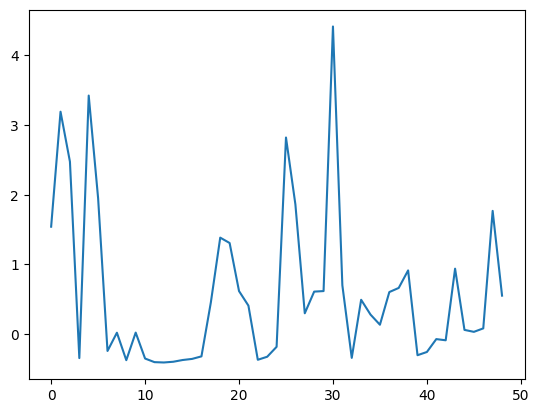

In [51]:
plt.plot(aud[7,1:])

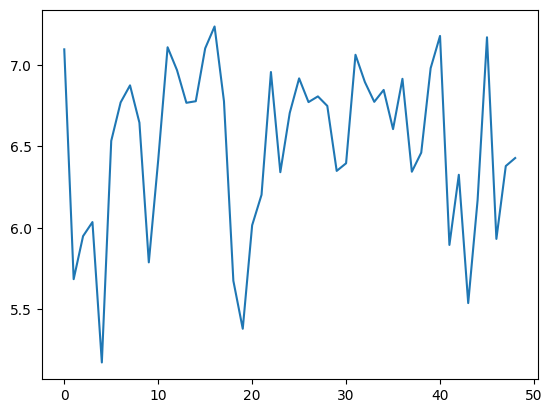

In [50]:
plt.plot(eeg[7,1:])

In [39]:
eeg.shape, aud.shape

((470, 50), (470, 50))

In [15]:
aud = np.array(audio_data)

In [16]:
eeg = []
for D_idx in range(0,len(eeg_data),int(250/64)):
    Ds = eeg_data[D_idx]
    eeg.append(combine_diagrams(Ds))

In [17]:
rips_comp = ripser(aud, maxdim=1)  # compute up to H2
diagrams = rips_comp['dgms']

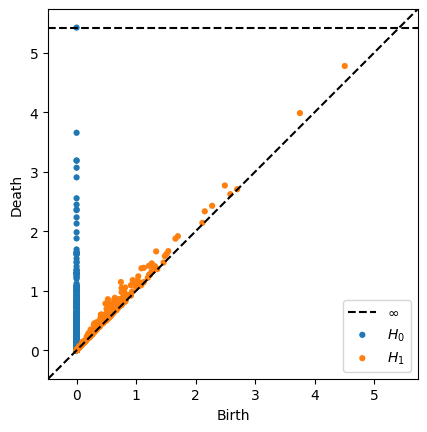

In [18]:
plot_diagrams(diagrams, show=True)

In [20]:
combine_diagrams(diagrams)

array([[0.00000000e+00, 5.14622545e-04, 0.00000000e+00],
       [0.00000000e+00, 8.13689665e-04, 0.00000000e+00],
       [0.00000000e+00, 8.91352363e-04, 0.00000000e+00],
       ...,
       [3.08773527e-03, 3.90231865e-03, 1.00000000e+00],
       [2.93379999e-03, 3.31522385e-03, 1.00000000e+00],
       [2.84209591e-03, 2.97859334e-03, 1.00000000e+00]])

In [68]:
X_feats_sphere = []
X_feats_square = []

X_pds_sphere = []
X_pds_square = []

y = []

for speed in ["slow", "fast"]:
    for band in ["theta", "alpha", "beta"]:
        for m in range(1): # len(subjects)
            for n in range(len(auds)):
                bb = subjects[m]
                ut = auds[n]
                try:
                    interp_maps = np.load(f"{san_disk}/eegs/harmonics/{speed}/{band}/bb{bb}_ut{ut}.npy")
                except FileNotFoundError:
                    print(f"File for bb{bb}_ut{ut} not found, skipping.")
                    continue

                y.append(0 if speed == "fast" else 1)

                with open(f'{san_disk}/audios/method_1/{speed}/ut{ut}_emb3_hilbert.json', 'r') as file:
                    aud = json.load(file)
                aud = np.array(aud)

                with open(f'{san_disk}/eegs/method_3/{band}/{speed}/bb{bb}_ut{ut}_cc_sphere.json', 'r') as file:
                    eeg_data = json.load(file)
                

                eeg = []
                for D_idx in range(0,len(eeg_data),int(250/64)):
                    Ds = eeg_data[D_idx]
                    eeg.append(combine_diagrams(Ds))

                if len(eeg) > len(aud):
                    eeg = eeg[:len(aud)]
                elif len(eeg) < len(aud):
                    aud = aud[:len(eeg)]

                feats = features_from_pd_list(eeg, t_grid)
                X_feats_sphere.append(feats)
                X_pds_sphere.append(eeg)
                
                
                with open(f'{san_disk}/eegs/method_3/{band}/{speed}/bb{bb}_ut{ut}_cc_square.json', 'r') as file:
                    eeg_data = json.load(file)

                with open(f'{san_disk}/audios/method_1/{speed}/ut{ut}_emb3_hilbert.json', 'r') as file:
                    aud = json.load(file)
                aud = np.array(aud)

                eeg = []
                for D_idx in range(0,len(eeg_data),int(250/64)):
                    Ds = eeg_data[D_idx]
                    eeg.append(combine_diagrams(Ds))

                if len(eeg) > len(aud):
                    eeg = eeg[:len(aud)]
                elif len(eeg) < len(aud):
                    aud = aud[:len(eeg)]


                feats = features_from_pd_list(eeg, t_grid)
                X_feats_square.append(feats)
                X_pds_square.append(eeg)

In [23]:
XF = []
yF = []
gF = []
XS = []
yS = []
gS = []

In [146]:
# emb = 64
# tau = ""
# band = "alpha"
# typp = "sphere"
# eid = 2
# tid = 0
# bid = 0
# tyd = 0
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for eid, emb in enumerate([30, 50, 64]):
        for tid, tau in enumerate(["", "_tau10"]):
            for bid, band in enumerate(["alpha", "theta", "beta"]):
                for tyd, typp in enumerate(["sphere", "square"]):
                    print(f"Working on case Embedding {eid}, Tau {tid}, Band {bid}, Type {tyd}")
                    if eid == 0:
                        continue
                    if eid == 1 and tid == 0 and bid == 0:
                        continue

                    XF = []
                    yF = []
                    gF = []
                    XS = []
                    yS = []
                    gS = []
                    for m in range(len(subjects)):
                        bb = subjects[m]
                        # print(f"Working on subject {bb}")
                        for n in range(len(auds)):
                                
                            ut = auds[n]
                            # Load audio file
                            if prop[m,n]:
                                for s in range(2):
                                    if s == 0:
                                        speed = 'fast'
                                    else:
                                        speed = 'slow'

                            # for eid, emb in enumerate([30, 50, 64]):
                            #     for tid, tau in enumerate(["", "_tau10"]):
                                    with open(f'{san_disk}/audios/method_1/{speed}/ut{ut}_emb{emb}{tau}_hilbert.json', 'r') as file:
                                        aud = json.load(file)
                                    aud = np.array(aud)
                                            
                                    eeg = []
                                    # for bid, band in enumerate(["alpha", "beta", "theta"]):
                                    with open(f'{san_disk}/eegs/method_3/{band}/{speed}/bb{bb}_ut{ut}_cc_{typp}.json', 'r') as file:
                                        eeg_data = json.load(file)
                                    
                                    eeg = []
                                    for D_idx in range(0,len(eeg_data),int(250/64)):
                                        Ds = eeg_data[D_idx]
                                        eeg.append(combine_diagrams(Ds))
                                    
                                    # eeg = np.array(eeg_data)
                                    # print(eeg.shape)
                                    # print(aud.shape)
                                    # eeg = eeg[::int(250/64)]
                                    # aud = aud[::10]

                                    if len(eeg) > aud.shape[0]:
                                        eeg = eeg[:aud.shape[0]]
                                    elif len(eeg) < aud.shape[0]:
                                        aud = aud[:len(eeg)]

                                    aud = ripser(aud, maxdim=1)  # compute up to H2
                                    aud = aud['dgms']
                                    aud = combine_diagrams(aud)

                                    # eeg = eeg.flatten()
                                    # aud = aud.flatten()

                                    # eeg = eeg[::59]
                                    # aud = aud[::59]

                                    if s == 0:
                                        XF.append(eeg)
                                        yF.append(aud)
                                        gF.append(m)
                                    else:
                                        XS.append(eeg)
                                        yS.append(aud)
                                        gS.append(m)
                    for i in range(153):#XF_aux:
                        for j in range(len(XF[i])):
                            mask = np.isfinite(XF[i][j][..., 1])  # death is column 1
                            XF[i][j] = XF[i][j][mask]

                        for j in range(len(XS[i])):
                            mask = np.isfinite(XS[i][j][..., 1])  # death is column 1
                            XS[i][j] = XS[i][j][mask]

                        mask = np.isfinite(yF[i][..., 1])  # death is column 1
                        yF[i] = yF[i][mask]
                        
                        mask = np.isfinite(yS[i][..., 1])  # death is column 1
                        yS[i] = yS[i][mask]
                    minim = 10000
                    minim0 = 10000
                    minim1 = 10000
                    minimy = 10000
                    # minim2 = 10000

                    for i in range(153):#XF_aux:
                        if len(XF[i]) < minim:
                            minim = len(XF[i])
                            # print(f"Current mininum ({len(XF[i])}, ~{XF[i][0].shape}")
                        for j in XF[i]:
                            j0 = j[j[:,2] == 0]
                            j1 = j[j[:,2] == 1]
                            if j0.shape[0] < minim0:
                                minim0 = j0.shape[0]
                            if j1.shape[0] < minim1:
                                minim1 = j1.shape[0]

                    for i in range(153):#XF_aux:
                        if len(XS[i]) < minim:
                            minim = len(XS[i])
                            # print(f"Current mininum ({len(XS[i])}, ~{XS[i][0].shape}")
                        for j in XS[i]:
                            j0 = j[j[:,2] == 0]
                            j1 = j[j[:,2] == 1]
                            if j0.shape[0] < minim0:
                                minim0 = j0.shape[0]
                            if j1.shape[0] < minim1:
                                minim1 = j1.shape[0]


                    for i in range(153):#XF_aux:
                        if yF[i].shape[0] < minimy:
                            minimy = yF[i].shape[0]
                            # print(f"Current mininum {yF[i].shape}")
                    for i in range(153):
                        XF[i] = XF[i][:minim]
                        for j in range(len(XF[i])):
                            j0 = XF[i][j][XF[i][j][:,2] == 0]
                            j1 = XF[i][j][XF[i][j][:,2] == 1]
                            j0 = j0[:minim0]
                            j1 = j1[:minim1]
                            # print(j0.shape, j1.shape, XF[i][j].shape)
                            XF[i][j] = np.concatenate([j0, j1])

                        XS[i] = XS[i][:minim]
                        for j in range(len(XS[i])):
                            j0 = XS[i][j][XS[i][j][:,2] == 0]
                            j1 = XS[i][j][XS[i][j][:,2] == 1]
                            j0 = j0[:minim0]
                            j1 = j1[:minim1]
                            XS[i][j] = np.concatenate([j0, j1])

                        yF[i] = yF[i][:minimy]
                        yS[i] = yS[i][:minimy]

                    XF = np.array(XF)
                    XS = np.array(XS)
                    yF = np.array(yF)
                    yS = np.array(yS)

                    
                    params = [{"alpha":2**i} for i in range(-5,5)]

                    ytestF, ypredF, scoreF, pearF = regress_models_2(XF, yF, gF, method = "Ridge", candidates=params)
                    ytestS, ypredS, scoreS, pearS = regress_models_2(XS, yS, gS, method = "Ridge", candidates=params)

                    if scoreF < scoreS:
                        print(f"Slow outperforms Fast with Ridge")
                    else:
                        print(f"Fast outperforms Slow with Ridge")

                    rows = []

                    for m in range(2):
                        for n in range(23 - m):
                            for s in range(2):
                                row = {
                                    "Model": 3,
                                    "Method": 0,
                                    "Subject": m*6 + 1,
                                    "Trial": n + 1,
                                    "Speed": s,
                                    "Band": bid,
                                    "Emb": eid,
                                    "Tau": tid,
                                    "Type": tyd,
                                    "Score": pearF[23*m + n] if s == 0 else pearS[23*m + n]
                                }
                                rows.append(row)


                    params = [{"alpha":2**i, "gamma": j} for i in range(-5,5) for j in [1e-3, 1e-2,5e-3]]

                    ytestF, ypredF, scoreF, pearF = regress_models_2(XF, yF, gF, method = "KRidge", candidates=params)
                    ytestS, ypredS, scoreS, pearS = regress_models_2(XS, yS, gS, method = "KRidge", candidates=params)

                    if scoreF < scoreS:
                        print(f"Slow outperforms Fast with KernelRidge")
                    else:
                        print(f"Fast outperforms Slow with KernelRidge")

                    for m in range(2):
                        for n in range(23 - m):
                            for s in range(2):
                                row = {
                                    "Model": 3,
                                    "Method": 1,
                                    "Subject": m*6 + 1,
                                    "Trial": n + 1,
                                    "Speed": s,
                                    "Band": bid,
                                    "Emb": eid,
                                    "Tau": tid,
                                    "Type": tyd,
                                    "Score": pearF[23*m + n] if s == 0 else pearS[23*m + n]
                                }
                                rows.append(row)
                    
                    
                    params = [{"n_components":5*i} for i in range(1,12,3)]

                    ytestF, ypredF, scoreF, pearF = regress_models_2(XF, yF, gF, method = "PLS", candidates=params)
                    ytestS, ypredS, scoreS, pearS = regress_models_2(XS, yS, gS, method = "PLS", candidates=params)
                    
                    if scoreF < scoreS:
                        print(f"Slow outperforms Fast with PLS")
                    else:
                        print(f"Fast outperforms Slow with PLS")
                    
                    for m in range(2):
                        for n in range(23 - m):
                            for s in range(2):
                                row = {
                                    "Model": 3,
                                    "Method": 2,
                                    "Subject": m*6 + 1,
                                    "Trial": n + 1,
                                    "Speed": s,
                                    "Band": bid,
                                    "Emb": eid,
                                    "Tau": tid,
                                    "Type": tyd,
                                    "Score": pearF[23*m + n] if s == 0 else pearS[23*m + n]
                                }
                                rows.append(row)

                    params = [{"hidden_layer_sizes":3*i, "max_iter": 600} for i in range(1,25,5)]

                    ytestF, ypredF, scoreF, pearF = regress_models_2(XF, yF, gF, method = "MLP", candidates=params)
                    ytestS, ypredS, scoreS, pearS = regress_models_2(XS, yS, gS, method = "MLP", candidates=params)

                    if scoreF < scoreS:
                        print(f"Slow outperforms Fast with MLP")
                    else:
                        print(f"Fast outperforms Slow with MLP")
                    for m in range(2):
                        for n in range(23 - m):
                            for s in range(2):
                                row = {
                                    "Model": 3,
                                    "Method": 3,
                                    "Subject": m*6 + 1,
                                    "Trial": n + 1,
                                    "Speed": s,
                                    "Band": bid,
                                    "Emb": eid,
                                    "Tau": tid,
                                    "Type": tyd,
                                    "Score": pearF[23*m + n] if s == 0 else pearS[23*m + n]
                                }
                                rows.append(row)


                    df_scores = pd.read_csv("scores_3.csv")
                    df_scores = pd.concat([df_scores, pd.DataFrame(rows)], ignore_index=True)
                    df_scores.to_csv("scores_3.csv", index=False)
                        

Working on case Embedding 0, Tau 0, Band 0, Type 0
Working on case Embedding 0, Tau 0, Band 0, Type 1
Working on case Embedding 0, Tau 0, Band 1, Type 0
Working on case Embedding 0, Tau 0, Band 1, Type 1
Working on case Embedding 0, Tau 0, Band 2, Type 0
Working on case Embedding 0, Tau 0, Band 2, Type 1
Working on case Embedding 0, Tau 1, Band 0, Type 0
Working on case Embedding 0, Tau 1, Band 0, Type 1
Working on case Embedding 0, Tau 1, Band 1, Type 0
Working on case Embedding 0, Tau 1, Band 1, Type 1
Working on case Embedding 0, Tau 1, Band 2, Type 0
Working on case Embedding 0, Tau 1, Band 2, Type 1
Working on case Embedding 1, Tau 0, Band 0, Type 0
Working on case Embedding 1, Tau 0, Band 0, Type 1
Working on case Embedding 1, Tau 0, Band 1, Type 0
Slow outperforms Fast with Ridge
Slow outperforms Fast with KernelRidge
Fast outperforms Slow with PLS
Fast outperforms Slow with MLP
Working on case Embedding 1, Tau 0, Band 1, Type 1
Slow outperforms Fast with Ridge
Slow outperforms 

In [133]:
for i in range(153):#XF_aux:
    for j in range(len(XF[i])):
        mask = np.isfinite(XF[i][j][..., 1])  # death is column 1
        XF[i][j] = XF[i][j][mask]

    for j in range(len(XS[i])):
        mask = np.isfinite(XS[i][j][..., 1])  # death is column 1
        XS[i][j] = XS[i][j][mask]

    mask = np.isfinite(yF[i][..., 1])  # death is column 1
    yF[i] = yF[i][mask]
    
    mask = np.isfinite(yS[i][..., 1])  # death is column 1
    yS[i] = yS[i][mask]

In [134]:
minim = 10000
minim0 = 10000
minim1 = 10000
# minim2 = 10000

for i in range(153):#XF_aux:
    if len(XF[i]) < minim:
        minim = len(XF[i])
        print(f"Current mininum ({len(XF[i])}, ~{XF[i][0].shape}")
    for j in XF[i]:
        j0 = j[j[:,2] == 0]
        j1 = j[j[:,2] == 1]
        if j0.shape[0] < minim0:
            minim0 = j0.shape[0]
        if j1.shape[0] < minim1:
            minim1 = j1.shape[0]

for i in range(153):#XF_aux:
    if len(XS[i]) < minim:
        minim = len(XS[i])
        print(f"Current mininum ({len(XS[i])}, ~{XS[i][0].shape}")
    for j in XS[i]:
        j0 = j[j[:,2] == 0]
        j1 = j[j[:,2] == 1]
        if j0.shape[0] < minim0:
            minim0 = j0.shape[0]
        if j1.shape[0] < minim1:
            minim1 = j1.shape[0]

    


Current mininum (320, ~(36, 3)
Current mininum (296, ~(27, 3)


In [137]:
minimy = 10000

for i in range(153):#XF_aux:
    if yF[i].shape[0] < minimy:
        minimy = yF[i].shape[0]
        print(f"Current mininum {yF[i].shape}")

Current mininum (628, 3)
Current mininum (606, 3)
Current mininum (553, 3)


In [138]:
minim0, minim1, minim, minimy

(5, 4, 296, 553)

In [73]:
X_aux = XF.copy()

In [139]:
for i in range(153):
    XF[i] = XF[i][:minim]
    for j in range(len(XF[i])):
        j0 = XF[i][j][XF[i][j][:,2] == 0]
        j1 = XF[i][j][XF[i][j][:,2] == 1]
        j0 = j0[:minim0]
        j1 = j1[:minim1]
        # print(j0.shape, j1.shape, XF[i][j].shape)
        XF[i][j] = np.concatenate([j0, j1])

    XS[i] = XS[i][:minim]
    for j in range(len(XS[i])):
        j0 = XS[i][j][XS[i][j][:,2] == 0]
        j1 = XS[i][j][XS[i][j][:,2] == 1]
        j0 = j0[:minim0]
        j1 = j1[:minim1]
        XS[i][j] = np.concatenate([j0, j1])

    yF[i] = yF[i][:minimy]
    yS[i] = yS[i][:minimy]

In [140]:
XF = np.array(XF)
XS = np.array(XS)
yF = np.array(yF)
yS = np.array(yS)

In [ ]:
yF

In [ ]:
# XF = XF[:,:,:,:2]
# XS = XS[:,:,:,:2]
# yF = yF[:,:,:2]
# yS = yS[:,:,:2]

In [ ]:
# PDs_clean = XF.copy()
# PDs_clean[..., 1] = np.where(np.isinf(XF[..., 1]), np.nan, XF[..., 1])

# PDs_cleanS = XS.copy()
# PDs_cleanS[..., 1] = np.where(np.isinf(XS[..., 1]), np.nan, XS[..., 1])

# PDs_cleany = yF.copy()
# PDs_cleany[..., 1] = np.where(np.isinf(yF[..., 1]), np.nan, yF[..., 1])

# PDs_cleanyS = yS.copy()
# PDs_cleanyS[..., 1] = np.where(np.isinf(yS[..., 1]), np.nan, yS[..., 1])

In [141]:
print(XF.shape, XS.shape, yF.shape, yS.shape)

(153, 296, 9, 3) (153, 296, 9, 3) (153, 553, 3) (153, 553, 3)


In [142]:
params = [{"alpha":2**i} for i in range(-5,5)]

ytestF, ypredF, scoreF, pearF = regress_models_2(XF, yF, gF, method = "Ridge", candidates=params, verb=1)
ytestS, ypredS, scoreS, pearS = regress_models_2(XS, yS, gS, method = "Ridge", candidates=params, verb=1)

if scoreF < scoreS:
    print(f"Slow outperforms Fast with Ridge")
else:
    print(f"Fast outperforms Slow with Ridge")

(153, 7992) (153, 888) (153,)
Starting Train Stage

Best hyperparameters: 9
Best CV Score: 0.9921054117630952
Starting Test Stage

Final Test Score: 0.8502387176759748
(153, 7992) (153, 888) (153,)
Starting Train Stage

Best hyperparameters: 0
Best CV Score: 0.9841427135766475
Starting Test Stage

Final Test Score: 0.9695271429840886
Slow outperforms Fast with Ridge


In [75]:
X_aux = np.array(X_aux)

In [78]:
X_aux = X_aux[:,:,:,:2]
X_aux.shape

(153, 296, 11, 2)

In [ ]:
minimy = 10000

for i in range(153):#XF_aux:
    if yF[i].shape[0] < minim:
        minim = yF[i].shape[0]
        print(f"Current mininum {yF[i].shape}")

Current mininum (629, 3)
Current mininum (607, 3)
Current mininum (554, 3)


In [29]:
minim = 10000

for i in range(153):#XF_aux:
    if len(XS[i]) < minim:
        minim = len(XS[i])
        print(f"Current mininum ({len(XS[i])}, ~{XS[i][0].shape}")

Current mininum (512, ~(22, 3)
Current mininum (474, ~(30, 3)


In [27]:
minim = 10000

for i in range(153):#XF_aux:
    if yS[i].shape[0] < minim:
        minim = yS[i].shape[0]
        print(f"Current mininum {yS[i].shape}")

Current mininum (883, 3)
Current mininum (811, 3)


## Method 4.

In [12]:
def method_4_regression(eeg, aud):
    X = eeg  # (958, 47, 3)
    X = X.reshape(X.shape[0], -1)              # (958, 141)
    y = aud                      # (958, 3)

    # Fit linear regression
    model = LinearRegression()
    model.fit(X, y)

    # Predict
    y_pred = model.predict(X)
    pearsons = [pearsonr(y[:, i], y_pred[:, i])[0] for i in range(y.shape[1])]
    mse = np.mean((y - y_pred) ** 2, axis=0)
    return np.array(pearsons), np.array(mse), model, y_pred

In [55]:
from persim import wasserstein, bottleneck

# D matriz T x T con distancias Wasserstein
def pairwise_wasserstein(pd_list, matching=False):
    T = len(pd_list)
    D = np.zeros((T,T))
    for i in range(T):
        for j in range(i+1, T):
            d = wasserstein(pd_list[i], pd_list[j], matching=matching)
            D[i,j] = d
            D[j,i] = d
    return D
def takens_numpy(x, m=3, tau=10):
    """Takens embedding simple para una serie 1D -> matriz (N-(m-1)tau, m)."""
    N = len(x) - (m-1)*tau
    if N <= 0:
        raise ValueError("Serie muy corta para estos parámetros (m, tau).")
    return np.vstack([x[i:i+N] for i in range(0, m*tau, tau)]).T


def takens_wasser(pd_list, m=3, tau=1, matching = False):
    T = len(pd_list) - (m-1)*tau
    if T <= 0:
        return
        # raise ValueError("Serie muy corta para estos parámetros (m, tau).")
    D = np.zeros((T,m))
    for i in range(0, T):
        for j in range(m):
            d = wasserstein(pd_list[i], pd_list[i + j*tau], matching=matching)
            D[i,j] = d
    return D

# embedding from D via MDS
from sklearn.manifold import MDS
def embed_from_distance_matrix(D, n_components=10):
    mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=0)
    Y = mds.fit_transform(D)
    return Y  # T x n_components


In [156]:
def combine_diagrams(Ds):
    """
    Convert [D0, D1] → (n_points_total, 3) array with homology dimension labels.
    """
    D0, D1 = Ds
    D0 = np.asarray(D0, dtype=float)
    D1 = np.asarray(D1, dtype=float)

    # Add homology dimension label as 3rd column
    D0_labeled = np.hstack([D0, np.zeros((len(D0), 1))])
    D1_labeled = np.hstack([D1, np.ones((len(D1), 1))])

    # Concatenate into one array
    return np.vstack([D0_labeled, D1_labeled])

def pd_basic_features(D):
    births, deaths = D[:,0], D[:,1]
    lifetimes = deaths - births
    return {
        "num": len(D),
        "mean": np.mean(lifetimes),
        "max": np.max(lifetimes),
        "sum": np.sum(lifetimes),
        "std": np.std(lifetimes)
    }

def persistence_entropy(D):
    lifetimes = D[:,1] - D[:,0]
    if np.sum(lifetimes) == 0:
        return 0.0
    p = lifetimes / np.sum(lifetimes)
    return -np.sum(p * np.log(p + 1e-10))

def betti_curve_from_diagram(diag: np.ndarray, t_grid: np.ndarray) -> np.ndarray:
    """Cuenta, para cada t en t_grid, cuántos intervalos (b,d) activan: b <= t < d.
    diag: array de pares (b,d) (puede contener d = inf)"""
    if len(diag) == 0:
        return np.zeros_like(t_grid, dtype=float)
    b = [case[0] for case in diag] # todos los births
    d = [case[1] for case in diag] # todos los deaths
    out = np.zeros_like(t_grid, dtype=float)
    for i, t in enumerate(t_grid):
        out[i] = np.sum((b <= t) & (t < d)) # número de intervalos de persistencia "vivos" en el tiempo t
    return out

def euler_curve_from_diagrams(diagrams: list[np.ndarray], t_grid: np.ndarray) -> np.ndarray:
    """E(t) = sum_k (-1)^k * beta_k(t)"""
    E = np.zeros_like(t_grid, dtype=float)
    for k, Dk in enumerate(diagrams):
        if len(Dk) == 0:
            continue
        E += ((-1)**k) * betti_curve_from_diagram(Dk, t_grid)
    return E


# ---------------------
# Paisajes de persistencia (versión simple)
# ---------------------
def _hat_height(t, b, d):
    # Triangular hat: max(0, min(t-b, d-t))
    if np.isinf(d):
        # Si la muerte es infinita, acotamos artificialmente (para visualización)
        d = b + 2.0
    return max(0.0, min(t - b, d - t))

def persistence_landscapes(diag: np.ndarray, t_grid: np.ndarray, k_max=3) -> np.ndarray:
    """Devuelve una matriz (k_max, len(t_grid)) con los k primeros paisajes."""
    L = np.zeros((k_max, len(t_grid)), dtype=float)
    if len(diag) == 0:
        return L
    for j, t in enumerate(t_grid):
        vals = [_hat_height(t, case[0], case[1]) for case in diag]
        vals.sort(reverse=True)
        m = min(k_max, len(vals))
        L[:m, j] = vals[:m]
    return L

def features_from_pd_list(D_list):
        feats = []
        t_grid = np.linspace(-1e-15, 2e-15, 50)
        for D in D_list:
            # min_t, max_t = D[:,0].min(), D[:,1].max()
            # t_grid = np.linspace(min_t, max_t, 50)
            b0 = betti_curve_from_diagram([case for case in D if case[2] < 0.5], t_grid) if len(D)>0 else np.zeros(t_grid)
            b1 = betti_curve_from_diagram([case for case in D if case[2] > 0.5], t_grid) if len(D)>1 else np.zeros(t_grid)
            E  = euler_curve_from_diagrams([[case for case in D if case[2] < 0.5], [case for case in D if case[2] > 0.5]], t_grid)
            L0  = persistence_landscapes([case for case in D if case[2] < 0.5], t_grid, k_max=3) if len(D)>1 else np.zeros((3,len(t_grid)))
            L1  = persistence_landscapes([case for case in D if case[2] > 0.5], t_grid, k_max=3) if len(D)>1 else np.zeros((3,len(t_grid)))
            lifetimes_0 = np.array([d - b for (b, d, dim) in D if dim == 0])
            finite_mask_0 = np.isfinite(lifetimes_0)
            filtered_arr_0 = lifetimes_0[finite_mask_0]

            mean_life_0 = filtered_arr_0.mean() if len(filtered_arr_0) > 0 else 0
            max_life_0 = filtered_arr_0.max() if len(filtered_arr_0) > 0 else 0
            var_life_0 = filtered_arr_0.var() if len(filtered_arr_0) > 0 else 0

            lifetimes_1 = np.array([d - b for (b, d, dim) in D if dim == 0])
            finite_mask_1 = np.isfinite(lifetimes_1)
            filtered_arr_1 = lifetimes_1[finite_mask_1]

            mean_life_1 = filtered_arr_1.mean() if len(filtered_arr_1) > 0 else 0
            max_life_1 = filtered_arr_1.max() if len(filtered_arr_1) > 0 else 0
            var_life_1 = filtered_arr_1.var() if len(filtered_arr_1) > 0 else 0

            num_infinite_0 = np.sum([np.isinf(d) for (_, d, dim) in D if dim == 0])
            num_infinite_1 = np.sum([np.isinf(d) for (_, d, dim) in D if dim == 1])

            if len(filtered_arr_0) > 0:
                probs_0 = filtered_arr_0 / filtered_arr_0.sum()
                entropy_0 = -np.sum(probs_0 * np.log(probs_0))
            else:
                entropy_0 = 0

            if len(filtered_arr_1) > 0:
                probs_1 = filtered_arr_1 / filtered_arr_1.sum()
                entropy_1 = -np.sum(probs_1 * np.log(probs_1))
            else:
                entropy_1 = 0

            feats.append([
                mean_life_0,
                max_life_0,
                var_life_0,
                num_infinite_0,
                entropy_0,
                np.trapz(b0, t_grid),          # área bajo Betti0
                b0.max(),                      # peak Betti0
                L0[0].max() if L0.size>0 else 0, # peak λ0
                np.trapz(np.abs(L0[0]), t_grid),  # p=1
                np.sqrt(np.trapz(L0[0]**2, t_grid)),  # p=2

                mean_life_1,
                max_life_1,
                var_life_1,
                num_infinite_1,
                entropy_1,
                np.trapz(b1, t_grid),          # área bajo Betti1
                b1.max(),                      # peak Betti1
                L1[0].max() if L1.size>0 else 0, # peak λ1
                np.trapz(np.abs(L1[0]), t_grid),  # p=1
                np.sqrt(np.trapz(L1[0]**2, t_grid)),  # p=2
                
                np.trapz(np.abs(E), t_grid),   # área Euler
            ])
        return np.array(feats)

In [2]:
import pandas as pd
df_score_check = pd.read_csv("scores_3.csv")

In [53]:
bb = "01"
ut = "01"
speed = "fast"
band = "alpha"


with open(f'{san_disk}/audios/method_1/{speed}/ut{ut}_emb30_tau10_hilbert.json', 'r') as file:
    aud = json.load(file)
aud = np.array(aud)

eeg_F = np.load(f'{san_disk}/eegs/method_4/{band}/{speed}/bb{bb}_ut{ut}_cc_sphere_emb30_tau10.npy', 'r')

eeg_F.shape, aud.shape

((670, 30), (670, 30))

In [32]:
def features_from_pd_list(D_list):
        feats = []
        t_grid = np.linspace(-1e-15, 2e-15, 50)
        for D in D_list:
            # min_t, max_t = D[:,0].min(), D[:,1].max()
            # t_grid = np.linspace(min_t, max_t, 50)
            b0 = betti_curve_from_diagram([case for case in D if case[2] < 0.5], t_grid) if len(D)>0 else np.zeros(t_grid)
            b1 = betti_curve_from_diagram([case for case in D if case[2] > 0.5], t_grid) if len(D)>1 else np.zeros(t_grid)
            E  = euler_curve_from_diagrams([[case for case in D if case[2] < 0.5], [case for case in D if case[2] > 0.5]], t_grid)
            L0  = persistence_landscapes([case for case in D if case[2] < 0.5], t_grid, k_max=3) if len(D)>1 else np.zeros((3,len(t_grid)))
            L1  = persistence_landscapes([case for case in D if case[2] > 0.5], t_grid, k_max=3) if len(D)>1 else np.zeros((3,len(t_grid)))
            lifetimes_0 = np.array([d - b for (b, d, dim) in D if dim == 0])
            finite_mask_0 = np.isfinite(lifetimes_0)
            filtered_arr_0 = lifetimes_0[finite_mask_0]

            mean_life_0 = filtered_arr_0.mean() if len(filtered_arr_0) > 0 else 0
            max_life_0 = filtered_arr_0.max() if len(filtered_arr_0) > 0 else 0
            var_life_0 = filtered_arr_0.var() if len(filtered_arr_0) > 0 else 0

            lifetimes_1 = np.array([d - b for (b, d, dim) in D if dim == 0])
            finite_mask_1 = np.isfinite(lifetimes_1)
            filtered_arr_1 = lifetimes_1[finite_mask_1]

            mean_life_1 = filtered_arr_1.mean() if len(filtered_arr_1) > 0 else 0
            max_life_1 = filtered_arr_1.max() if len(filtered_arr_1) > 0 else 0
            var_life_1 = filtered_arr_1.var() if len(filtered_arr_1) > 0 else 0

            num_infinite_0 = np.sum([np.isinf(d) for (_, d, dim) in D if dim == 0])
            num_infinite_1 = np.sum([np.isinf(d) for (_, d, dim) in D if dim == 1])

            if len(filtered_arr_0) > 0:
                probs_0 = filtered_arr_0 / filtered_arr_0.sum()
                entropy_0 = -np.sum(probs_0 * np.log(probs_0))
            else:
                entropy_0 = 0

            if len(filtered_arr_1) > 0:
                probs_1 = filtered_arr_1 / filtered_arr_1.sum()
                entropy_1 = -np.sum(probs_1 * np.log(probs_1))
            else:
                entropy_1 = 0

            feats.append([
                mean_life_0,
                max_life_0,
                var_life_0,
                num_infinite_0,
                entropy_0,
                np.trapz(b0, t_grid),          # área bajo Betti0
                b0.max(),                      # peak Betti0
                L0[0].max() if L0.size>0 else 0, # peak λ0
                np.trapz(np.abs(L0[0]), t_grid),  # p=1
                np.sqrt(np.trapz(L0[0]**2, t_grid)),  # p=2

                mean_life_1,
                max_life_1,
                var_life_1,
                num_infinite_1,
                entropy_1,
                np.trapz(b1, t_grid),          # área bajo Betti1
                b1.max(),                      # peak Betti1
                L1[0].max() if L1.size>0 else 0, # peak λ1
                np.trapz(np.abs(L1[0]), t_grid),  # p=1
                np.sqrt(np.trapz(L1[0]**2, t_grid)),  # p=2
                
                np.trapz(np.abs(E), t_grid),   # área Euler
            ])
        return np.array(feats)

In [47]:
emb = 30
tau = "_tau10"
band = "alpha"
typp = "sphere"
eid = 0
tid = 1
bid = 0
tyd = 0

XF = []
yF = []
XS = []
yS = []
gF = []
gS = []

for m in range(len(subjects)):
    bb = subjects[m]
    print(f"Working on subject {bb}")
    for n in range(3):#len(auds)):
            
        ut = auds[n]
        # Load audio file
        if prop[m,n]:
            for s in range(2):
                if s == 0:
                    speed = 'fast'
                else:
                    speed = 'slow'

        # for eid, emb in enumerate([30, 50, 64]):
        #     for tid, tau in enumerate(["", "_tau10"]):
                with open(f'{san_disk}/audios/method_1/{speed}/ut{ut}_emb{emb}{tau}_hilbert.json', 'r') as file:
                    aud = json.load(file)
                aud = np.array(aud)
                        
                eeg = []
                # for bid, band in enumerate(["alpha", "beta", "theta"]):
                
                if typp == "sphere":
                    with open(f'{san_disk}/eegs/method_3/{band}/{speed}/bb{bb}_ut{ut}_cc_{typp}.json', 'r') as file:
                        eeg_data = json.load(file)
                
                    eeg = []
                    for D_idx in range(0,len(eeg_data),int(250/64)):
                        Ds = eeg_data[D_idx]
                        eeg.append(combine_diagrams(Ds))  
                    eeg = features_from_pd_list(eeg)
                
                else:
                    eeg = np.load(f'{san_disk}/eegs/method_4_1/{band}/{speed}/bb{bb}_ut{ut}_cc_{typp}.npy')
                # print((aud.shape[0] + (tid*9 + 1)*emb)/3)
                # print(len(eeg))
                    #
                aud = ripser(aud, maxdim=1)  # compute up to H2
                aud = aud['dgms']
                aud = combine_diagrams(aud)
                aud = features_from_pd_list([aud])
                # print(aud.shape)
                # print(eeg.shape)
                

                # print(eeg.shape)
                # print(aud.shape)
                # eeg = eeg[::int(250/64)]
                # aud = aud[::10]
                # if eeg.shape[0] > aud.shape[0]:
                #     eeg = eeg[:aud.shape[0]]
                # elif eeg.shape[0] < aud.shape[0]:
                #     aud = aud[:eeg.shape[0]]

                # eeg = eeg.flatten()
                # aud = aud.flatten()

                # eeg = eeg[::59]
                # aud = aud[::59]

                if s == 0:
                    XF.append(eeg)
                    yF.append(aud)
                    gF.append(m)
                else:
                    XS.append(eeg)
                    yS.append(aud)
                    gS.append(m)


Working on subject 01
Working on subject 02
Working on subject 04
Working on subject 09
Working on subject 15
Working on subject 37
Working on subject 79


In [34]:
print(len(XF), len(yF), len(gF), len(XS), len(yS), len(gS))

19 19 19 19 19 19


In [35]:
prop[:,:3].sum(axis=1)

array([3., 2., 3., 2., 3., 3., 3.])

In [ ]:
# minim = 10000

# for i in XF:
#     if i.shape[0] < minim:
#         minim = i.shape[0]
#         print(f"Current minimum {i.shape}")

Current minimum (320, 21)


In [61]:
bb = "01"
ut = "03"
speed = "slow"
band = "beta"

with open(f'{san_disk}/eegs/method_3/{band}/{speed}/bb{bb}_ut{ut}_cc_sphere.json', 'r') as file:
    eeg_data = json.load(file)

len(eeg_data)

2879

In [52]:
for i in range(len(XF)):
    XF[i] = XF[i][:minim]

XF = np.array(XF)

In [58]:
XF2 = []
for i in XF:
    lines = []
    for j in range(i.shape[1]):
        line = takens_numpy(i[:,j])
        lines.append(line)
    XF2.append(lines)
XF2 = np.array(XF2)

In [59]:
XF2.shape

(19, 21, 300, 3)

In [57]:
line.shape

(300, 3)

In [48]:
params = [{"alpha":2**i} for i in range(-5,5)]

ytestF, ypredF, scoreF, pearF = regress_models_2(XF, yF, gF, method = "Ridge", candidates=params, verb=1)
ytestS, ypredS, scoreS, pearS = regress_models_2(XS, yS, gS, method = "Ridge", candidates=params, verb=1)

if scoreF < scoreS:
    print(f"Slow outperforms Fast with Ridge")
else:
    print(f"Fast outperforms Slow with Ridge")

(19, 6720) (19, 21) (19,)
Starting Train Stage

Best hyperparameters: 0
Best CV Score: 0.9999988433627656
Starting Test Stage

Final Test Score: 0.9999989591377415
(19, 10752) (19, 21) (19,)
Starting Train Stage

Best hyperparameters: 0
Best CV Score: 0.9999996345042147
Starting Test Stage

Final Test Score: 0.9999995642156874
Slow outperforms Fast with Ridge


In [51]:
XF = np.array(XF)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (19,) + inhomogeneous part.

In [47]:
bb = "01"
ut = "08"
speed = "slow"
band = "alpha"


with open(f'{san_disk}/audios/method_1/{speed}/ut{ut}_emb50_hilbert.json', 'r') as file:
    aud = json.load(file)
aud = np.array(aud)

eeg_S = np.load(f'{san_disk}/eegs/method_4/{band}/{speed}/bb{bb}_ut{ut}_cc_square_emb30_tau10.npy', 'r')

pear_S, mse_S, model_S, y_pred_S = method_4_regression(eeg, aud)

ValueError: Found input variables with inconsistent numbers of samples: [670, 1534]

In [48]:
eeg.shape, aud.shape

((670, 30), (1534, 50))

In [44]:
eeg_S.shape, eeg_F.shape

((670, 30), (670, 30))

In [45]:
np.linalg.norm(eeg_S - eeg_F)

3.046291270329939e-13

## Plots

In [41]:
bb = '02'
ut = '02'
speed = 'fast'
band = 'theta'

with open(f'{san_disk}/audios/method_1/{speed}/ut{ut}_emb3_hilbert.json', 'r') as file:
        aud = json.load(file)
aud = np.array(aud)
        
eeg = []
for c in range(47):
    with open(f'{san_disk}/eegs/method_1/{speed}/bb{bb}_ut{ut}_ch{c+1}_emb3.json', 'r') as file:
        eeg_data = json.load(file)
    eeg.append(np.array(eeg_data))
eeg = np.stack(eeg, axis=1)

pearsons, mses, model, y_pred_ex_1 = method_1_regression(eeg, aud)

In [42]:
with open(f'{san_disk}/eegs/method_2/{band}/{speed}/bb{bb}_ut{ut}_emb3.json', 'r') as file:
    eeg_data = json.load(file)

eeg = np.array(eeg_data)
eeg = eeg[::int(250/64)]
if eeg.shape[0] > aud.shape[0]:
    eeg = eeg[:aud.shape[0]]
elif eeg.shape[0] < aud.shape[0]:
    aud = aud[:eeg.shape[0]]

pearsons, mses, model, y_pred_ex_2 = method_2_regression(eeg, aud)

In [43]:
with open(f'{san_disk}/eegs/method_3/{band}/{speed}/bb{bb}_ut{ut}_cc_sphere.json', 'r') as file:
    eeg_data = json.load(file)


eeg = []
for D_idx in range(0,len(eeg_data),int(250/64)):
    Ds = eeg_data[D_idx]
    eeg.append(combine_diagrams(Ds))

if len(eeg) > len(aud):
    eeg = eeg[:len(aud)]
elif len(eeg) < len(aud):
    aud = aud[:len(eeg)]

feats = features_from_pd_list(eeg, t_grid)
pearsons, mses, model, y_pred_ex_3 = method_3_regression(feats, aud)

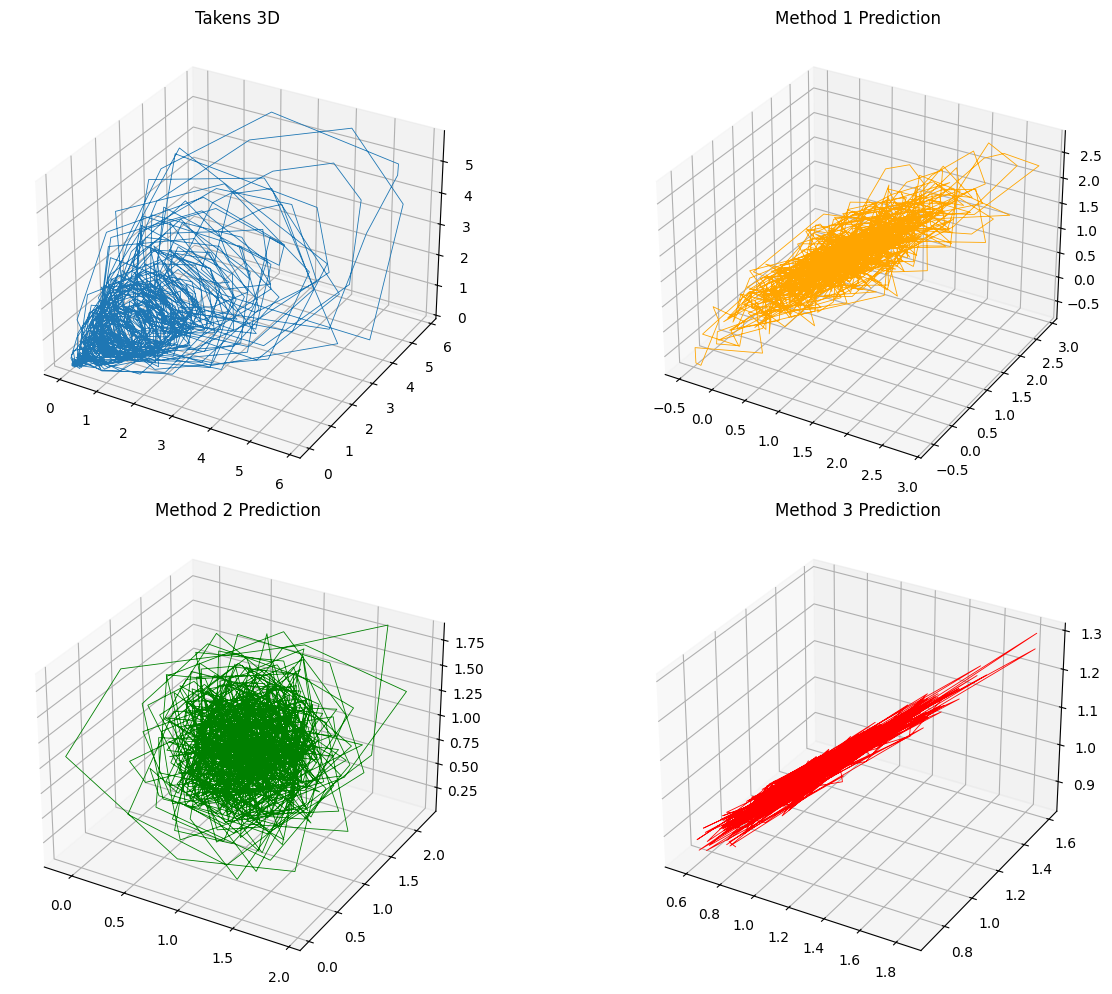

In [44]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(221, projection='3d')
ax.plot(aud[:,0], aud[:,1], aud[:,2], lw=0.6)
ax.set_title("Takens 3D")

ax = fig.add_subplot(222, projection='3d')
ax.plot(y_pred_ex_1[:,0], y_pred_ex_1[:,1], y_pred_ex_1[:,2], color='orange', lw=0.6)
ax.set_title("Method 1 Prediction")

ax = fig.add_subplot(223, projection='3d')
ax.plot(y_pred_ex_2[:,0], y_pred_ex_2[:,1], y_pred_ex_2[:,2], color='green', lw=0.6)
ax.set_title("Method 2 Prediction")

ax = fig.add_subplot(224, projection='3d')
ax.plot(y_pred_ex_3[:,0], y_pred_ex_3[:,1], y_pred_ex_3[:,2], color='red', lw=0.6)
ax.set_title("Method 3 Prediction")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Method 3 Prediction')

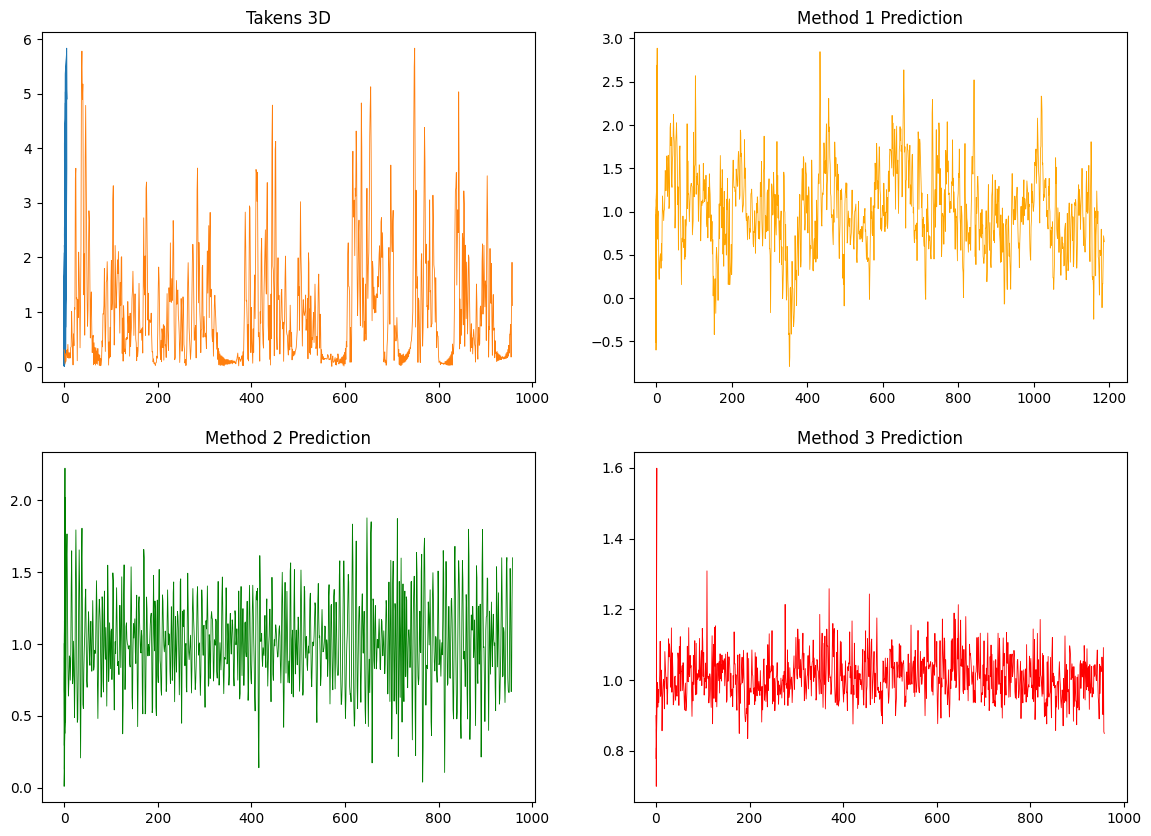

In [45]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(221)
ax.plot(aud[:,0], aud[:,1], aud[:,2], lw=0.6)
ax.set_title("Takens 3D")

ax = fig.add_subplot(222)
ax.plot(y_pred_ex_1[:,0], y_pred_ex_1[:,1], y_pred_ex_1[:,2], color='orange', lw=0.6)
ax.set_title("Method 1 Prediction")

ax = fig.add_subplot(223)
ax.plot(y_pred_ex_2[:,0], y_pred_ex_2[:,1], y_pred_ex_2[:,2], color='green', lw=0.6)
ax.set_title("Method 2 Prediction")

ax = fig.add_subplot(224)
ax.plot(y_pred_ex_3[:,0], y_pred_ex_3[:,1], y_pred_ex_3[:,2], color='red', lw=0.6)
ax.set_title("Method 3 Prediction")

C:\Users\marti\AppData\Local\Temp\ipykernel_8296\3471449344.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(aud[::int(Fs/fs)])


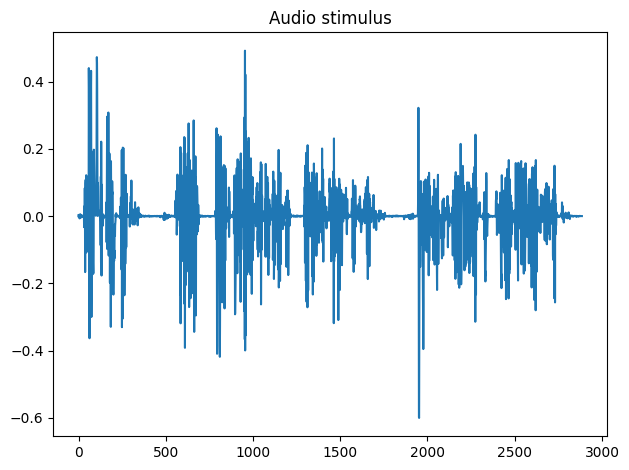

In [366]:
data = loadmat('data/sound_sep/fast/bb01_ut01.mat')
eeg = data["subeeg"]
aud = data["y"]
aud = aud[:,0]
Fs = data["Fs"]
fs = 250

plt.plot(aud[::int(Fs/fs)])
plt.title('Audio stimulus')
plt.tight_layout()
plt.show()

In [ ]:
band = "alpha"

bb = '01'
with open(f'{san_disk}/eegs/method_2/{band}/{speed}/bb{bb}_ut{ut}_emb3.json', 'r') as file:
    eeg_data = json.load(file)

eeg = np.array(eeg_data)
eeg = eeg[::int(250/64)]
if eeg.shape[0] > aud.shape[0]:
    eeg = eeg[:aud.shape[0]]
elif eeg.shape[0] < aud.shape[0]:
    aud = aud[:eeg.shape[0]]

pearsons, mses, model, y_pred_ex_2_1 = method_2_regression(eeg, aud)

bb = '02'
with open(f'{san_disk}/eegs/method_2/{band}/{speed}/bb{bb}_ut{ut}_emb3.json', 'r') as file:
    eeg_data = json.load(file)

eeg = np.array(eeg_data)
eeg = eeg[::int(250/64)]
if eeg.shape[0] > aud.shape[0]:
    eeg = eeg[:aud.shape[0]]
elif eeg.shape[0] < aud.shape[0]:
    aud = aud[:eeg.shape[0]]

pearsons, mses, model, y_pred_ex_2_2 = method_2_regression(eeg, aud)

bb = '37'
with open(f'{san_disk}/eegs/method_2/{band}/{speed}/bb{bb}_ut{ut}_emb3.json', 'r') as file:
    eeg_data = json.load(file)

eeg = np.array(eeg_data)
eeg = eeg[::int(250/64)]
if eeg.shape[0] > aud.shape[0]:
    eeg = eeg[:aud.shape[0]]
elif eeg.shape[0] < aud.shape[0]:
    aud = aud[:eeg.shape[0]]

pearsons, mses, model, y_pred_ex_2_37 = method_2_regression(eeg, aud)

beta


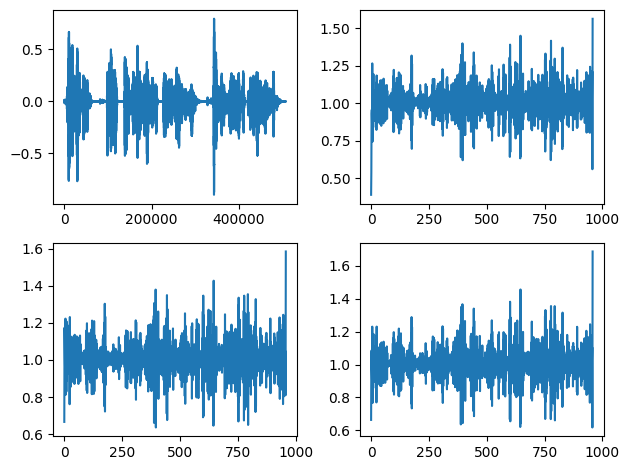

In [371]:
data = loadmat('data/sound_sep/fast/bb01_ut01.mat')
subeeg = data["subeeg"]
aud = data["y"]
aud = aud[:,0]
Fs = data["Fs"]
fs = 250
# aud = aud[::int(Fs/fs)]
# aud = aud[::int(fs/64)]

plt.subplot(2,2,1)
plt.plot(aud)

with open(f'{san_disk}/audios/method_1/{speed}/ut{ut}_emb3_hilbert.json', 'r') as file:
        aud = json.load(file)
aud = np.array(aud)

plt.subplot(2,2,2)
plt.plot(y_pred_ex_2_1[:,0])

plt.subplot(2,2,3)
plt.plot(y_pred_ex_2_2[:,0])

plt.subplot(2,2,4)
plt.plot(y_pred_ex_2_37[:,0])

plt.tight_layout()
plt.show()

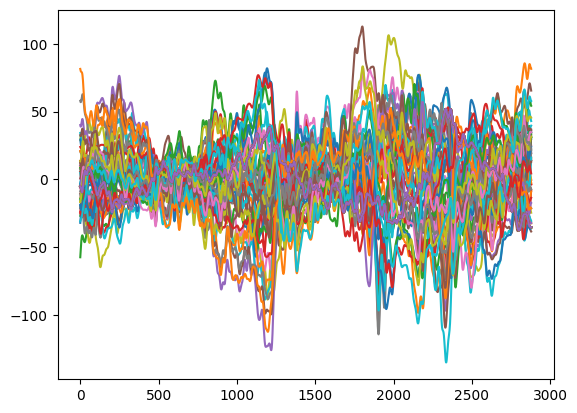

In [276]:
plt.plot(eeg)

In [322]:
import numpy as np
from scipy.signal import hilbert, butter, filtfilt, find_peaks
from scipy.interpolate import interp1d
import librosa

In [323]:
# ---------------------------------------------------------
# 1. Hilbert envelope
# ---------------------------------------------------------
def envelope_hilbert(y, sr, smooth_ms=10):
    """Hilbert transform envelope, optionally smoothed with moving average."""
    analytic = hilbert(y)
    env = np.abs(analytic)
    win = int(smooth_ms * sr / 1000)
    if win > 1:
        env = np.convolve(env, np.ones(win)/win, mode='same')
    return env


# ---------------------------------------------------------
# 2. Rectify + Lowpass filter envelope
# ---------------------------------------------------------
def envelope_lowpass(y, sr, cutoff_hz=20, order=4):
    """Envelope via full-wave rectification and Butterworth lowpass."""
    rect = np.abs(y)
    nyq = 0.5 * sr
    b, a = butter(order, cutoff_hz / nyq, btype='low')
    env = filtfilt(b, a, rect)
    return env


# ---------------------------------------------------------
# 3. RMS (root-mean-square) envelope
# ---------------------------------------------------------
def envelope_rms(y, sr, frame_ms=20, hop_ms=None):
    """RMS energy envelope over frames."""
    frame = int(frame_ms * sr / 1000)
    hop = int(hop_ms * sr / 1000) if hop_ms else frame // 2
    rms = librosa.feature.rms(y=y, frame_length=frame, hop_length=hop)[0]
    # Upsample to original signal length
    env = np.repeat(rms, hop)
    return env[:len(y)]


# ---------------------------------------------------------
# 4. Peak interpolation envelope
# ---------------------------------------------------------
def envelope_peaks(y, sr, peak_thresh=0.01, min_dist_ms=5):
    """Envelope by finding peaks and interpolating between them."""
    rect = np.abs(y)
    min_dist = int(min_dist_ms * sr / 1000)
    peaks, _ = find_peaks(rect, height=np.max(rect)*peak_thresh, distance=min_dist)

    if len(peaks) < 2:  # fallback: return rectified signal
        return rect

    xs = np.concatenate(([0], peaks, [len(y)-1]))
    ys = np.concatenate(([rect[0]], rect[peaks], [rect[-1]]))
    f = interp1d(xs, ys, kind='linear')
    env = f(np.arange(len(y)))
    return env


# ---------------------------------------------------------
# 5. Exponential smoothing envelope (attack/release)
# ---------------------------------------------------------
def envelope_exponential(y, sr, attack_ms=1, release_ms=200):
    """Envelope follower with exponential attack/release smoothing."""
    x = np.abs(y)
    a_a = np.exp(-1.0 / (sr * attack_ms / 1000.0))
    a_r = np.exp(-1.0 / (sr * release_ms / 1000.0))
    env = np.zeros_like(x)
    for n in range(1, len(x)):
        coeff = a_a if x[n] > env[n-1] else a_r
        env[n] = coeff * env[n-1] + (1 - coeff) * x[n]
    return env

In [336]:
x = np.linspace(0,1, 959)

In [373]:
from scipy.interpolate import interp1d

f = interp1d(x, y_pred_ex_2_2[:,0], kind='linear')  # 'linear', 'quadratic', etc.
x_new = np.linspace(0, 1, 959*3*int(Fs))
y_up = f(x_new)

# y_up = y_pred_ex_2_2[:,0]


C:\Users\marti\AppData\Local\Temp\ipykernel_8296\3180075154.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_new = np.linspace(0, 1, 959*3*int(Fs))


In [374]:
y_up = (y_up - np.mean(y_up))/ np.std(y_up)

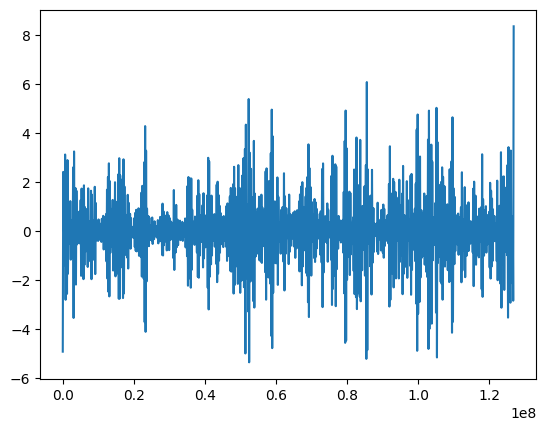

In [375]:
plt.plot(y_up)

In [362]:
env_ex_1 = envelope_hilbert(y_up, 250)
env_ex_2 = envelope_lowpass(y_up, 250)
env_ex_3 = envelope_rms(y_up, 250)
env_ex_4 = envelope_peaks(y_up, 250)
env_ex_5 = envelope_exponential(y_up, 250)


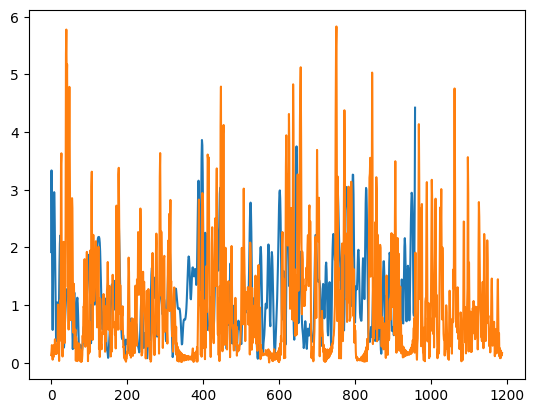

In [364]:
plt.plot(env_ex_1)
plt.plot(aud[:,0])

In [303]:
y_max_ex = y_pred_ex_2_2.max(axis=1)
y_min_ex = y_pred_ex_2_2.min(axis=1)

In [304]:
eeg = subeeg[:,good]
eeg = eeg[::int(250/64)]
eeg = np.array(eeg)
env_max_ex = eeg.max(axis=1)
env_min_ex = eeg.min(axis=1)

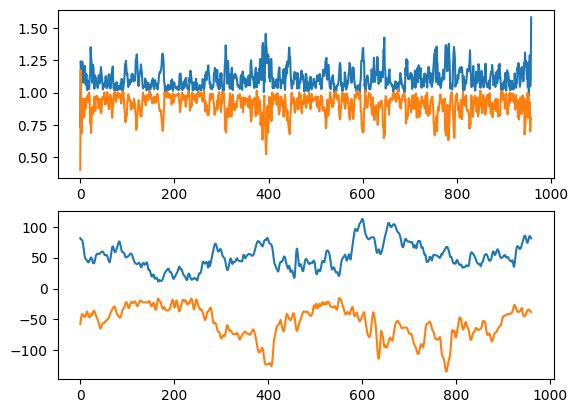

In [320]:
plt.subplot(2,1,1)
plt.plot(y_max_ex)
plt.plot(y_min_ex)

plt.subplot(2,1,2)
plt.plot(env_max_ex)
plt.plot(env_min_ex)

In [3]:
import pandas as pd
from scipy.stats import ttest_rel, binomtest
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf



def test_case(idxx=0):

    df_scores = pd.read_csv(f"scores_{idxx}.csv")

    factors = ["Model", "Method", "Band", "Emb", "Tau", "Type"]

    results = []

    # Loop through all combinations of factors + subject as blocking factor
    for keys, subdf in df_scores.groupby(factors + ["Subject"]):
        slow = subdf[subdf["Speed"] == 0]["Score"]
        fast = subdf[subdf["Speed"] == 1]["Score"]

        # Require both speeds present
        if len(slow) > 0 and len(fast) > 0:
            # Pair by Trial
            merged = pd.merge(
                subdf[subdf["Speed"]==1], 
                subdf[subdf["Speed"]==0], 
                on="Trial", 
                suffixes=("_slow","_fast")
            )

            if len(merged) > 1:  # at least 2 paired samples
                t_stat, p_val = ttest_rel(
                    merged["Score_slow"], merged["Score_fast"], alternative="greater"
                )

                results.append({
                    "Model": keys[0],
                    "Method": keys[1],
                    "Band": keys[2],
                    "Emb": keys[3],
                    "Tau": keys[4],
                    "Type": keys[5],
                    "Subject": keys[6],
                    "NumPairs": len(merged),
                    "T_stat": t_stat,
                    "P_value": p_val,
                    "FastMean": merged["Score_fast"].mean(),
                    "SlowMean": merged["Score_slow"].mean()
                })

    df_stats = pd.DataFrame(results)
    df_stats.to_csv(f"speed_ttest_results_{idxx}.csv", index=False)
    print("Subject-level tests done!")

    for i in range(4):
        df_comp = df_stats.copy()
        df_comp = df_comp[df_comp["Method"] == i]
        df_comp["SlowWins"] = df_comp["SlowMean"] > df_comp["FastMean"]
        num_wins = df_comp["SlowWins"].sum()
        n = len(df_comp)

        binom_res = binomtest(num_wins, n, 0.5, alternative="greater")
        print(f"Model{idxx} on method{i}: {binom_res}")

    agg = df_stats.groupby("Subject")[["SlowMean","FastMean"]].mean()
    t_stat, p_val = ttest_rel(agg["SlowMean"], agg["FastMean"], alternative="greater")

    print("Aggregated population test:")
    print("t =", t_stat, "p =", p_val)



    df_stats["P_FDR"] = multipletests(df_stats["P_value"], method="fdr_bh")[1]
    df_stats["Significant"] = df_stats["P_FDR"] < 0.05

    df_stats.to_csv(f"speed_ttest_FDR_results_{idxx}.csv", index=False)
    print("T-tests + FDR saved!")



In [3]:
import statsmodels.formula.api as smf

model_band = smf.mixedlm(
    "Score ~ Speed * C(Band)",
    df_scores,
    groups=df_scores["Subject"]
).fit()


print(model_band.summary())

NameError: name 'df_scores' is not defined

In [26]:
df_stats = pd.read_csv("combined_ttest.csv")
df_comp = df_stats.copy()
df_comp = df_comp[df_comp["Model"] == 7]
# df_comp = df_comp[df_comp["Method"] == 0]
df_comp = df_comp[df_comp["Band"] != 2]
df_comp["SlowWins"] = df_comp["SlowMean"] > df_comp["FastMean"]
num_wins = df_comp["SlowWins"].sum()
n = len(df_comp)

binom_res = binomtest(num_wins, n, 0.5, alternative="greater")
print(f"Model{4} on method{0}: {binom_res}")

Model4 on method0: BinomTestResult(k=124, n=192, alternative='greater', statistic=0.6458333333333334, pvalue=3.22805195012947e-05)


In [72]:
model_band = smf.mixedlm(
    "Score ~ Speed * C(Tau)",
    df_scores,
    groups=df_scores["Subject"]
).fit()


print(model_band.summary())

c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


           Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Score   
No. Observations:   12960     Method:               REML    
No. Groups:         2         Scale:                0.0558  
Min. group size:    6336      Log-Likelihood:       292.7791
Max. group size:    6624      Converged:            Yes     
Mean group size:    6480.0                                  
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.093    0.014  6.744 0.000  0.066  0.120
C(Tau)[T.1]       -0.033    0.006 -5.680 0.000 -0.045 -0.022
Speed              0.028    0.006  4.827 0.000  0.017  0.040
Speed:C(Tau)[T.1]  0.025    0.008  3.059 0.002  0.009  0.042
Group Var          0.000                                    



c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [20]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np

# basic cleaning
df = pd.read_csv("scores_7.csv")
df = df.dropna(subset=["Score"])
df = df[df["Band"] != 2]        # remove rows with missing Score
df["Subject"] = df["Subject"].astype("category")
df["Trial"]   = df["Trial"].astype("category")
df["Band"]    = df["Band"].astype("category")   # categorical factors
# ... do same for Model, Method, Emb, Tau, Type if they are labels

formula = "Score ~ Speed * C(Method) + C(Model) + C(Method) + C(Emb) + C(Tau) + C(Type)"

vc = {"Trial": "0 + C(Trial)"}   # crossed random intercept per Trial

md = smf.mixedlm(formula, df, groups=df["Subject"], vc_formula=vc, re_formula="1")
mfit = md.fit(reml=True, method="lbfgs")   # try 'powell' or 'nelder-mead' if convergence issues
print(mfit.summary())


             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   Score    
No. Observations:     8640      Method:               REML     
No. Groups:           2         Scale:                0.0362   
Min. group size:      4224      Log-Likelihood:       1973.1354
Max. group size:      4416      Converged:            Yes      
Mean group size:      4320.0                                   
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.071    0.011  6.614 0.000  0.050  0.092
C(Method)[T.1]       -0.073    0.008 -8.919 0.000 -0.089 -0.057
C(Method)[T.2]        0.081    0.008  9.896 0.000  0.065  0.097
C(Method)[T.3]        0.064    0.008  7.790 0.000  0.048  0.080
C(Emb)[T.1]          -0.012    0.005 -2.349 0.019 -0.022 -0.002
C(Emb)[T.2]          -0.014    0.005 -2.881 0.004 -0.

c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [21]:
summary_table = mfit.summary().tables[1]
coef_df = summary_table.copy()

# Convert numeric columns properly
for col in ["Coef.", "Std.Err.", "z", "P>|z|"]:
    coef_df[col] = pd.to_numeric(coef_df[col], errors='coerce')
coef_df = coef_df.dropna(subset=["P>|z|"])
coef_df['P>|z|'] = coef_df['P>|z|'].astype(float)

# Run FDR correction (Benjamini–Hochberg)
rejected, p_corr, _, _ = multipletests(coef_df['P>|z|'], alpha=0.05, method='fdr_bh')

# Add new columns to the table
coef_df['p_fdr'] = p_corr
coef_df['sig_fdr'] = rejected  # True = still significant after FDR

print(coef_df[['Coef.', 'P>|z|', 'p_fdr', 'sig_fdr']])

                      Coef.  P>|z|     p_fdr  sig_fdr
Intercept             0.071  0.000  0.000000     True
C(Method)[T.1]       -0.073  0.000  0.000000     True
C(Method)[T.2]        0.081  0.000  0.000000     True
C(Method)[T.3]        0.064  0.000  0.000000     True
C(Emb)[T.1]          -0.012  0.019  0.025333     True
C(Emb)[T.2]          -0.014  0.004  0.006000     True
C(Tau)[T.1]          -0.017  0.000  0.000000     True
C(Type)[T.1]         -0.015  0.000  0.000000     True
Speed                 0.031  0.000  0.000000     True
Speed:C(Method)[T.1] -0.001  0.929  0.929000    False
Speed:C(Method)[T.2] -0.017  0.148  0.177600    False
Speed:C(Method)[T.3] -0.015  0.206  0.224727    False


In [10]:
for i in range(9):
    test_case(i)

Subject-level tests done!
Model0 on method0: BinomTestResult(k=2, n=2, alternative='greater', statistic=1.0, pvalue=0.25)
Model0 on method1: BinomTestResult(k=2, n=2, alternative='greater', statistic=1.0, pvalue=0.25)
Model0 on method2: BinomTestResult(k=2, n=2, alternative='greater', statistic=1.0, pvalue=0.25)
Model0 on method3: BinomTestResult(k=1, n=2, alternative='greater', statistic=0.5, pvalue=0.75)
Aggregated population test:
t = 1.1734969007525489 p = 0.22464503935192498
T-tests + FDR saved!
Subject-level tests done!
Model1 on method0: BinomTestResult(k=7, n=12, alternative='greater', statistic=0.5833333333333334, pvalue=0.38720703125)
Model1 on method1: BinomTestResult(k=5, n=12, alternative='greater', statistic=0.4166666666666667, pvalue=0.80615234375)
Model1 on method2: BinomTestResult(k=7, n=12, alternative='greater', statistic=0.5833333333333334, pvalue=0.38720703125)
Model1 on method3: BinomTestResult(k=7, n=12, alternative='greater', statistic=0.5833333333333334, pvalue

In [64]:
df_comp = df_stats.copy()
df_comp["SlowWins"] = df_comp["SlowMean"] > df_comp["FastMean"]
num_wins = df_comp["SlowWins"].sum()
n = len(df_comp)

binom_res = binomtest(num_wins, n, 0.5, alternative="greater")
print(binom_res)


BinomTestResult(k=210, n=288, alternative='greater', statistic=0.7291666666666666, pvalue=1.904695160554645e-15)


In [65]:
agg = df_stats.groupby("Subject")[["SlowMean","FastMean"]].mean()
t_stat, p_val = ttest_rel(agg["SlowMean"], agg["FastMean"], alternative="greater")

print("Aggregated population test:")
print("t =", t_stat, "p =", p_val)

Aggregated population test:
t = 1.0208859721468784 p = 0.2467103662365577


In [66]:
from statsmodels.stats.multitest import multipletests


df_stats["P_FDR"] = multipletests(df_stats["P_value"], method="fdr_bh")[1]
df_stats["Significant"] = df_stats["P_FDR"] < 0.05

df_stats.to_csv("speed_ttest_FDR_results_2.csv", index=False)
print("T-tests + FDR saved!")


T-tests + FDR saved!
